In [4]:
# General
import os, time
import requests, glob, warnings, zipfile
import numpy as np
import pandas as pd
import datetime as dt
import tables as tb
from collections import OrderedDict
pd.options.display.max_columns = 24

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation

# Cartopy & geopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
#from cartopy.feature import ShapelyFeature
#from cartopy.io.shapereader import Reader
from geopy import distance

%config Completer.use_jedi = False

# Madrid

Raw data summary:

  - Raw data: [link](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=f3c0f7d512273410VgnVCM2000000c205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default)
  - Control stations: [link](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=9e42c176313eb410VgnVCM1000000b205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default)
  - Number of files: 256, three files per month (CSV, TXT, and XML).
  - Size of files: 220MB for CSV, 311MB for TXT, and 1022MB for XML.
  - Time span: 1/1/2001 - 30/4/2022.
  - Total number of gases: 14
  - Total number of stations: 24

## Download raw data

In [12]:
city = 'madrid'
years = np.arange(2001, 2022)
n_years = years.shape[0]
url_l = [
    'https://datos.madrid.es/egob/catalogo/201200-29-calidad-aire-horario.zip',
    'https://datos.madrid.es/egob/catalogo/201200-30-calidad-aire-horario.zip',
    'https://datos.madrid.es/egob/catalogo/201200-13-calidad-aire-horario.zip',
    'https://datos.madrid.es/egob/catalogo/201200-14-calidad-aire-horario.zip',
    'https://datos.madrid.es/egob/catalogo/201200-15-calidad-aire-horario.zip',
    'https://datos.madrid.es/egob/catalogo/201200-16-calidad-aire-horario.zip',
    'https://datos.madrid.es/egob/catalogo/201200-17-calidad-aire-horario.zip',
    'https://datos.madrid.es/egob/catalogo/201200-18-calidad-aire-horario.zip',
    'https://datos.madrid.es/egob/catalogo/201200-19-calidad-aire-horario.zip',
    'https://datos.madrid.es/egob/catalogo/201200-20-calidad-aire-horario.zip',
    'https://datos.madrid.es/egob/catalogo/201200-21-calidad-aire-horario.zip',
    'https://datos.madrid.es/egob/catalogo/201200-22-calidad-aire-horario.zip',
    'https://datos.madrid.es/egob/catalogo/201200-23-calidad-aire-horario.zip',
    'https://datos.madrid.es/egob/catalogo/201200-26-calidad-aire-horario.zip',
    'https://datos.madrid.es/egob/catalogo/201200-27-calidad-aire-horario.zip',
    'https://datos.madrid.es/egob/catalogo/201200-28-calidad-aire-horario.zip',
    'https://datos.madrid.es/egob/catalogo/201200-10306313-calidad-aire-horario.zip',
    'https://datos.madrid.es/egob/catalogo/201200-10306314-calidad-aire-horario.zip',
    'https://datos.madrid.es/egob/catalogo/201200-42-calidad-aire-horario.zip',
    'https://datos.madrid.es/egob/catalogo/201200-10306316-calidad-aire-horario.zip',
    'https://datos.madrid.es/egob/catalogo/201200-10306317-calidad-aire-horario.zip'
]
url_d = dict(zip(years, url_l))

url_st = 'https://datos.madrid.es/egob/catalogo/212629-1-estaciones-control-aire.csv'

In [22]:
tic = time.time()
for year in years:
    print('Fechting {}...'.format(year))
    r = requests.get(url_d[year])
    if r.status_code == 200:
        fname = '../data/{}/raw/{}.zip'.format(city, year)
        with open(fname, 'wb') as f:
            f.write(r.content)
        with zipfile.ZipFile(fname, 'r') as zipped:
            zipped.extractall(os.path.dirname(fname))

print('Fechting stations file...')
r = requests.get(url_st)
if r.status_code == 200:  
    with open('../data/{}/other/stations.csv'.format(city), 'wb') as f:
        f.write(r.content)
print('It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic))))

Fechting 2001...
Fechting 2002...
Fechting 2003...
Fechting 2004...
Fechting 2005...
Fechting 2006...
Fechting 2007...
Fechting 2008...
Fechting 2009...
Fechting 2010...
Fechting 2011...
Fechting 2012...
Fechting 2013...
Fechting 2014...
Fechting 2015...
Fechting 2016...
Fechting 2017...
Fechting 2018...
Fechting 2019...
Fechting 2020...
Fechting 2021...
Fechting stations file...
It took 00:00:59 in total


In [23]:
!du -h ../data/madrid/raw/

1.6G	../data/madrid/raw/


In [253]:
!find ../data/madrid/raw/ -type f -name '*.csv' -exec du -ch {} + | grep total$

197M	total


## Helpful

Dictionary of station codes and names:

In [2]:
folder = '../data/madrid/'
df_st = pd.read_csv(folder + 'other/stations.csv', sep=';', encoding='latin')
sc_map = OrderedDict(zip(df_st.CODIGO_CORTO.astype(str).str.zfill(2), df_st.ESTACION))
# And the reversed dictionary
sn_map = OrderedDict({v: k for k, v in sc_map.items()})
print(len(sc_map))
sc_map

24


OrderedDict([('04', 'Pza. de España'),
             ('08', 'Escuelas Aguirre'),
             ('11', 'Avda. Ramón y Cajal'),
             ('16', 'Arturo Soria'),
             ('17', 'Villaverde'),
             ('18', 'Farolillo'),
             ('24', 'Casa de Campo'),
             ('27', 'Barajas Pueblo'),
             ('35', 'Pza. del Carmen'),
             ('36', 'Moratalaz'),
             ('38', 'Cuatro Caminos'),
             ('39', 'Barrio del Pilar'),
             ('40', 'Vallecas'),
             ('47', 'Mendez Alvaro'),
             ('48', 'Castellana'),
             ('49', 'Parque del Retiro'),
             ('50', 'Plaza Castilla'),
             ('54', 'Ensanche de Vallecas'),
             ('55', 'Urb. Embajada'),
             ('56', 'Pza. Elíptica'),
             ('57', 'Sanchinarro'),
             ('58', 'El Pardo'),
             ('59', 'Juan Carlos I'),
             ('60', 'Tres Olivos')])

Dictionary of variable codes and names:

In [3]:
vc_map = OrderedDict()
vc_map['01'] = 'SO2'
vc_map['06'] = 'CO'
vc_map['07'] = 'NO'
vc_map['08'] = 'NO2'
vc_map['09'] = 'PM25'
vc_map['10'] = 'PM10'
vc_map['12'] = 'NOx'
vc_map['14'] = 'O3'
vc_map['20'] = 'TOL'
vc_map['30'] = 'BEN'
vc_map['35'] = 'EBE'
vc_map['42'] = 'TCH'
vc_map['43'] = 'CH4'
vc_map['44'] = 'NMHC'
#vc_map['37'] = 'MXY' # Does not appear in the raw data
#vc_map['38'] = 'PXY' # Does not appear in the raw data
#vc_map['39'] = 'OXY' # Does not appear in the raw data
#vc_map['-1'] = 'BTX' # Does not appear in the raw data
# And the reversed dictionary
vn_map = OrderedDict({v: k for k, v in vc_map.items()})
len(vc_map)

vc_map_pretty = OrderedDict()
vc_map_pretty['01'] = 'SO$_2$'
vc_map_pretty['06'] = 'CO'
vc_map_pretty['07'] = 'NO'
vc_map_pretty['08'] = 'NO$_2$'
vc_map_pretty['09'] = 'PM$_{2.5}$'
vc_map_pretty['10'] = 'PM$_{10}$'
vc_map_pretty['12'] = 'NO$_x$'
vc_map_pretty['14'] = 'O$_3$'
vc_map_pretty['20'] = 'TOL'
vc_map_pretty['30'] = 'BEN'
vc_map_pretty['35'] = 'EBE'
vc_map_pretty['42'] = 'TCH'
vc_map_pretty['43'] = 'CH$_4$'
vc_map_pretty['44'] = 'NMHC'
len(vc_map_pretty)

14

In [4]:
months_d = dict(zip(['ene', 'feb', 'mar', 'abr', 'may', 'jun', 'jul', 'ago', 'sep', 'oct', 'nov', 'dic'],
                    range(1, 13)))
df_v = pd.DataFrame(columns=['file', 'year', 'month'])
df_v.file = [f for f in os.listdir(folder + 'raw/csv/') if os.path.splitext(f)[1] == '.csv']    
df_v.year = ('20' + df_v.file.str[-6:-4]).map(int)
df_v.month = df_v.file.str[0:3].str.lower().map(months_d)
df_v.set_index('file', inplace=True)
df_v.sort_values(['year', 'month'], inplace=True)
raw_files = df_v.index.values

Gases measured in $\mu$g and in mg:

In [5]:
gases_in_mug = ['01', '07', '08', '09', '10', '12', '14', '20', '30', '35']
gases_in_mg = ['06', '42', '43', '44']

## Transfer raw data

### Transfer raw (2001 - April 2022)

The final file will look like this:
```
01h_flat_rawSep.h5 (file)
|-- station (group)
    |-- variable (carray) -> concentration: time (rows) + value (columns)
```

In [6]:
def process_gas_st(df, sc, vc):
    ret = df.loc[(df.ESTACION == sc) & (df.MAGNITUD == vc), 'H01':'H24':2]
    mask = df.loc[(df.ESTACION == sc) & (df.MAGNITUD == vc), 'V01':'V24':2] == 'V'
    mask.columns = ret.columns
    ret[~mask] = np.nan
    ret['date'] = pd.to_datetime({'year': df.ANO, 'month':df.MES, 'day':df.DIA})
    ret = ret.set_index('date').stack(dropna=False).reset_index()
    ret.columns = ['date', 'hour', 'value']
    # Extract and include hour
    ret.hour = ret.apply(lambda x: str(int(x['hour'][-2:]) - 1) + ':00', axis=1)
    ret.date = pd.to_datetime(ret['date'].astype(str) + ' ' + ret['hour'])
    # Should not happen: if ret.shape[0] == 0: return pd.DataFrame()
    ret.date = ret.date.astype('int64') // 1e9
    return ret[['date', 'value']]

def add_meta(h5_file, d_meta={}):
    # Add basic meta-information
    node = h5_file.root
    node._v_attrs['sc_map'] = sc_map
    node._v_attrs['sn_map'] = sn_map
    node._v_attrs['vc_map'] = vc_map
    node._v_attrs['vc_map_pretty'] = vc_map_pretty
    node._v_attrs['vn_map'] = vn_map
    node._v_attrs['time_resolution'] = '01h'
    node._v_attrs['gases_in_mug'] = gases_in_mug
    node._v_attrs['gases_in_mg'] = gases_in_mg
    for k, v in d_meta.items():
        node._v_attrs[k] = v

def transfer_raw(raw_files, out_path):
    # Parameters for the hdf5 file
    filters = tb.Filters(complib='blosc:lz4hc', complevel=9)
    dtype = tb.Float64Atom()
    tic = time.time()
    d = {}
    year = 2000
    for idx, f in enumerate(raw_files):
        if idx % 12 == 0:
            year += 1
            print('Working on {}...'.format(year))
        df = pd.read_csv(os.path.join(folder, 'raw/csv', f), sep=';')
        df.ESTACION = df.ESTACION.astype(str).str.zfill(2)
        df.MAGNITUD = df.MAGNITUD.astype(str).str.zfill(2)
        for sc in sc_map.keys():
            for vc in vc_map.keys():
                if df.loc[(df.ESTACION == sc) & (df.MAGNITUD == vc)].shape[0] == 0: continue
                df_g = process_gas_st(df, sc, vc)
                if (sc, vc) in d.keys():
                    d[(sc, vc)] = pd.concat([d[(sc, vc)], df_g])
                else:
                    d[(sc, vc)] = df_g
    # Transfer into HDF5
    with tb.open_file(out_path, mode='a', filters=filters) as h5_file, \
         warnings.catch_warnings() as w:
        warnings.simplefilter('ignore', tb.NaturalNameWarning)
        for k in d.keys():
            h5_file.create_carray(obj=d[k].values, atom=dtype, where='/s{}'.format(k[0]),
                                  name='v{}'.format(k[1]), createparents=True)
            vc_sc = pd.DataFrame(d.keys(), columns=['sc', 'vc']).groupby('vc')['sc'].unique()
            vc_sc.sort_index(inplace=True)
            vc_sc_map = OrderedDict(zip(vc_sc.index, vc_sc.map(list)))
        add_meta(h5_file, {'vc_sc_map': vc_sc_map})
    return 'It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic)))

In [21]:
out_path = '../data/madrid/clean/01h_flat_rawSep.h5'
transfer_raw(raw_files, out_path)

Working on 2001...
Working on 2002...
Working on 2003...
Working on 2004...
Working on 2005...
Working on 2006...
Working on 2007...
Working on 2008...
Working on 2009...
Working on 2010...
Working on 2011...
Working on 2012...
Working on 2013...
Working on 2014...
Working on 2015...
Working on 2016...
Working on 2017...
Working on 2018...
Working on 2019...
Working on 2020...
Working on 2021...
Working on 2022...


'It took 00:15:04 in total'

### Transfer combined (2010 - April 2022)

The final file will look like this:
```
01h_flat_raw.h5 (file)
|-- variable (carray) -> concentration: time (rows) + stations (columns)
```

Same as before, but combining all stations for each gas:

In [7]:
def copy_meta(h5_in, h5_out, l_meta=[], d_meta={}):
    # Copy (and maybe add) basic meta-information
    for k in l_meta:
        h5_out.root._v_attrs[k] = h5_in.root._v_attrs[k]
    for k, v in d_meta.items():
        h5_out.root._v_attrs[k] = v


def transfer_comb(in_path, out_path, vc_exc=[], start_date='1/1/2001', end_date='31/08/2021'):
    # Parameters for the hdf5 file
    filters = tb.Filters(complib='blosc:lz4hc', complevel=9)
    tic = time.time()
    # We compute the vc --> sc map again, in case it differs in this date range
    vc_sc_map = OrderedDict()
    # Also, we compute the vc --> vn[pretty] again, in case there are excluded variables
    vc_map_copy = vc_map.copy()
    vc_map_pretty_copy = vc_map_pretty.copy()
    with tb.open_file(in_path, mode='r') as h5_in, \
         tb.open_file(out_path, mode='a', filters=filters) as h5_out, \
         warnings.catch_warnings() as w:
        warnings.simplefilter('ignore', tb.NaturalNameWarning)
        for idx, vc in enumerate(vc_map.keys()):
            if vc in vc_exc: # If vc is excluded, remove from the dicts
                vc_map_copy.pop(vc)
                vc_map_pretty_copy.pop(vc)
                continue
            print('Working on {}...'.format(vc_map[vc]))
            stations_v = []
            df_v = pd.DataFrame(index=pd.date_range(start_date, end_date, freq='1h').astype('int64') // 1e9)
            for sc in sc_map.keys():
                n = '/s{}/v{}'.format(sc, vc)
                if n not in h5_in.root:
                    continue
                stations_v.append(sc)
                aux = h5_in.root[n][:]
                aux = pd.DataFrame(data=aux[:, 1], index=aux[:, 0].astype(int), columns=[sc])
                df_v = pd.merge(df_v, aux, left_index=True, right_index=True, how='left')
            # Transfer into new hdf5 file
            node = h5_out.create_carray(obj=df_v.reset_index().values, createparents=True,
                                          where='/', name='v{}'.format(vc))
            node._v_attrs['columns'] = ['time_since_epoch'] + list(df_v.columns)
            vc_sc_map[vc] = list(df_v.columns)
            if df_v.columns.tolist() != stations_v:
                print('Ouch!')
        vn_map_copy = OrderedDict({v: k for k, v in vc_map_copy.items()})
        copy_meta(h5_in, h5_out, ['sc_map', 'sn_map', 'time_resolution', 'gases_in_mug', 'gases_in_mg'],
                  {'vc_map': vc_map_copy, 'vn_map': vn_map_copy,
                   'vc_sc_map': vc_sc_map, 'vc_map_pretty': vc_map_pretty_copy,
                   'initial_dt': dt.datetime(*[int(s) for s in start_date.split('/')[::-1]])})
    return 'It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic)))

Here, we exclude TCH, CH4 and NMHC (42, 43, 44):

In [69]:
in_path = '../data/madrid/clean/01h_flat_rawSep.h5'
out_path = '../data/madrid/clean/01h_flat_raw.h5'
transfer_comb(in_path, out_path, vc_exc=['42', '43', '44'],
              start_date='1/1/2010', end_date='30/04/2022')

Working on SO2...
Working on CO...
Working on NO...
Working on NO2...
Working on PM25...
Working on PM10...
Working on NOx...
Working on O3...
Working on TOL...
Working on BEN...
Working on EBE...


'It took 00:00:06 in total'

## Transfer into mesh-grid (2010- April 2022)

- **TCH, CH4, NMHC**: Too few stations, so we removed them.
- **PM2.5, EBE, TOL, BEN**: Ok from 2010 on.
- **SO2, CO**: Ok, but they lose 5 stations in 2021.
- **NO2, NO, NOx, PM10, O3**: Ok.

### Checks and definitions

**Big caveat here!** `np.meshgrid -> indexing='xy'|'ij'`

- Using `indexing='xy'` (by default) returns a meshgrid with Cartesian indexing. This implies that indexing on the resulting array is reversed: `[j, i]`. If the inputs have length `M` and `N`, the outputs are of shape `(N, M)`.
- Using `indexing='ij'` returns a meshgrid with matrix indexing. This implies that indexing on the resulting array is "natural": `[i, j]`. If the inputs have length `M` and `N`, the outputs are of shape `(M, N)`.

Therefore, we can use `'xy'` indexing and then transpose the resulting arrays, or just use `'ij'` indexing. Check `np.meshgrid` docs for more details.

In [8]:
np.meshgrid?

In [9]:
from scipy.interpolate import griddata
griddata?

Mesh-grid shape:

In [10]:
folder = '../data/madrid/'
df_st = pd.read_csv(folder + 'other/stations.csv', sep=';', encoding='latin')
df_locs = df_st[['CODIGO_CORTO', 'LONGITUD', 'LATITUD']].copy()
df_locs.columns = ['c', 'lng', 'lat']
df_locs.loc[:, 'c'] = df_locs.loc[:, 'c'].astype(str).str.zfill(2).copy()
df_locs.set_index('c', inplace=True)
df_locs.head().T

c,04,08,11,16,17
lng,-3.712257,-3.682316,-3.677349,-3.639242,-3.713317
lat,40.423882,40.421553,40.451473,40.440046,40.347147


**Caveat**: To compute the location of the interpolation points (mesh-grid elements), we take the center of the regions.  
For example, in a 4x3 mesh-grid there are 5 sides on the x-axis and 4 in the y-axis, but we take the middle points:
```
 _____ _____ _____ _____
|     |     |     |     |
|  ·  |  ·  |  ·  |  ·  |
|_____|_____|_____|_____|
|     |     |     |     |
|  ·  |  ·  |  ·  |  ·  |
|_____|_____|_____|_____|
|     |     |     |     |
|  ·  |  ·  |  ·  |  ·  |
|_____|_____|_____|_____|
```

Assuming `indexing='ij'`:

In [11]:
offset = 0.004
print('Offset length: {:0.2f}m'.format(distance.distance((0, 0), (0, offset)).m))
lat_dist = distance.distance((df_locs.lat.min() - offset, df_locs.lng.iloc[0]),
                             (df_locs.lat.max() + offset, df_locs.lng.iloc[0]))
print('Distance between min & max latitude: {:0.2f}km'.format(lat_dist.km))
lng_dist = distance.distance((df_locs.lat.iloc[0], df_locs.lng.min() - offset),
                             (df_locs.lat.iloc[0], df_locs.lng.max() + offset))
print('Distance between min & max longitude: {:0.2f}km'.format(lng_dist.km))
print()

i, j = 40, 40
print('for a {} x {} mesh-grid ({} nodes):'.format(i, j, i * j))
print('for latitude: {:0.2f}m'.format(lat_dist.m / i))
print('for longitude: {:0.2f}m'.format(lng_dist.m / j))
print()

i, j = 30, 30
print('for a {} x {} mesh-grid ({} nodes):'.format(i, j, i * j))
print('for latitude: {:0.2f}m'.format(lat_dist.m / i))
print('for longitude: {:0.2f}m'.format(lng_dist.m / j))
print()

i, j = 40, 35
print('for a {} x {} mesh-grid ({} nodes):'.format(i, j, i * j))
print('for latitude: {:0.2f}m'.format(lat_dist.m / i))
print('for longitude: {:0.2f}m'.format(lng_dist.m / j))
print()


i, j = 35, 30
print('for a {} x {} mesh-grid ({} nodes):'.format(i, j, i * j))
print('for latitude: {:0.2f}m'.format(lat_dist.m / i))
print('for longitude: {:0.2f}m'.format(lng_dist.m / j))
print()

Offset length: 445.28m
Distance between min & max latitude: 19.87km
Distance between min & max longitude: 17.19km

for a 40 x 40 mesh-grid (1600 nodes):
for latitude: 496.70m
for longitude: 429.80m

for a 30 x 30 mesh-grid (900 nodes):
for latitude: 662.27m
for longitude: 573.07m

for a 40 x 35 mesh-grid (1400 nodes):
for latitude: 496.70m
for longitude: 491.20m

for a 35 x 30 mesh-grid (1050 nodes):
for latitude: 567.66m
for longitude: 573.07m



In [12]:
from scipy.interpolate import griddata

def interp_map(arr, ij, I, J, method='nearest', fill_value=np.nan):
    '''
    ij : Latitude and longitude of the available sensors.
    I : i-coordinates of the mesh grid.
    J : j-coordinates of the mesh grid.
    arr : Values used to interpolate.
    '''
    return griddata(ij, arr, (I, J), method=method, fill_value=fill_value)

def check_coverage(df, grid_shape, offset=0.004, irange=None, jrange=None):
    ij = df.values
    i = ij[:, 0]
    j = ij[:, 1]
    irange = (i.max(), i.min()) # <-- CAVEAT! Since we use ij, latitude decreases as i increases
    jrange = (j.min(), j.max())
    istep = (irange[1] - irange[0] + 2 * offset) / grid_shape[0]
    jstep = (jrange[1] - jrange[0] + 2 * offset) / grid_shape[1]
    inew = np.linspace(irange[0] + offset - abs(istep)/2, irange[1] - offset + abs(istep)/2, grid_shape[0]) # <-- CAVEAT!
    jnew = np.linspace(jrange[0] - offset + jstep/2, jrange[1] + offset - jstep/2, grid_shape[1])
    I, J = np.meshgrid(inew, jnew, indexing='ij')
    interp = interp_map(df.index.astype(int).values, df.values, I, J, method='nearest')
    print(interp.shape)
    print('(i_step, j_step) = ({:.5f}, {:.5f})'.format(inew[1] - inew[0], jnew[1] - jnew[0]))
    print('(min_interp, max_interp) = ({}, {})'.format(interp.min().round(2), interp.max().round(2)))
    print('n_unique_interp = {}'.format(np.unique(interp).shape[0]))
    fig, axs = plt.subplots(1, 3)
    fig.set_size_inches(15, 5)
    axs[0].scatter(df.lng, df.lat, s=15)
    axs[0].set_xticks(jnew)
    axs[0].set_yticks(inew)
    axs[0].set_xticklabels([])
    axs[0].set_yticklabels([])
    axs[0].grid()
    axs[1].imshow(interp)
    axs[2].hist(interp.ravel(), bins=24, edgecolor='k')
    plt.show()
    return I, J, interp

In the next plot:
- 1st plot: Location of the stations (blue) and the interpolation points (intersection of grey lines).
- 2nd plot: Interpolated values on the map. The values used to interpolate are the index of df.
- 3rd plot: Histogram showing the count of appearances of each value.

(35, 30)
(i_step, j_step) = (-0.00513, 0.00675)
(min_interp, max_interp) = (4, 60)
n_unique_interp = 24


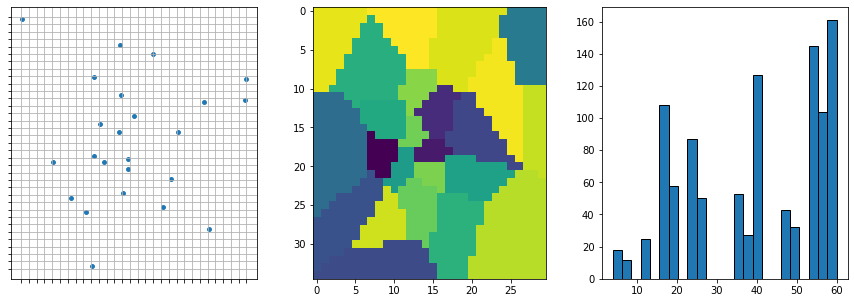

In [13]:
offset = 0.004
grid_shape = (35, 30)
I, J, interp = check_coverage(df_locs[['lat', 'lng']], grid_shape, offset=offset)

Number and percentage of sensor apearances when using nearest neighbors:

In [14]:
aux = pd.DataFrame(interp.ravel()).value_counts()
pd.DataFrame(data={'n_counts': aux, 'perc': aux / (35 * 30) * 100}).round(2).T

,54,24,57,39,59,17,40,18,58,27,16,60,36,55,47,56,38,11,50,4,35,8,49,48
n_counts,111.00,87.00,73.00,69.00,63.0,60.00,58.00,58.00,52.00,50.00,48.00,46.00,39.00,34.00,33.00,31.00,27.00,25.00,20.0,18.00,14.00,12.00,12.00,10.00
perc,10.57,8.29,6.95,6.57,6.0,5.71,5.52,5.52,4.95,4.76,4.57,4.38,3.71,3.24,3.14,2.95,2.57,2.38,1.9,1.71,1.33,1.14,1.14,0.95


In the next plot:
- Blue dots: Location of the sensors.
- Orange dots: Interpolation points (`i` by `j` dots).
- Gray lines: Delimitation of the spatial coverage and mesh-grid (`i+1` by `j+1` lines).

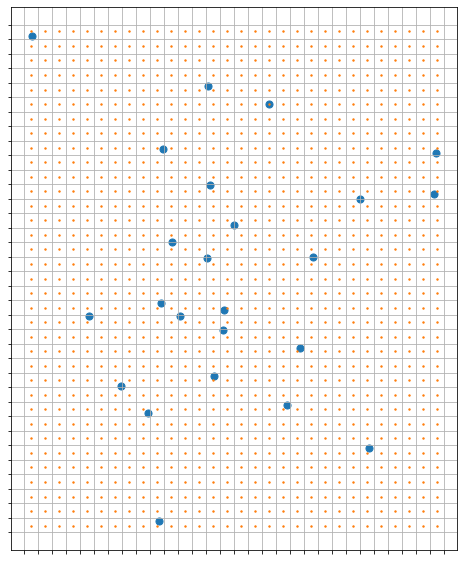

In [15]:
grid_shape = (35, 30)
fig, ax = plt.subplots()
fig.set_size_inches(8, 10)
# Interpolation points
irange = (df_locs.lat.max(), df_locs.lat.min()) # <-- CAVEAT! Since we use ij, latitude decreases as i increases
jrange = (df_locs.lng.min(), df_locs.lng.max())
istep = (irange[1] - irange[0] + 2 * offset) / grid_shape[0]
jstep = (jrange[1] - jrange[0] + 2 * offset) / grid_shape[1]
inew = np.linspace(irange[0] + offset - abs(istep)/2, irange[1] - offset + abs(istep)/2, grid_shape[0]) # <-- CAVEAT!
jnew = np.linspace(jrange[0] - offset + jstep/2, jrange[1] + offset - jstep/2, grid_shape[1])
I, J = np.meshgrid(inew, jnew, indexing='ij')
ax.scatter(df_locs.lng, df_locs.lat, s=50)
ax.scatter((J.ravel()), I.ravel(), s=2)
# Mesh-grid
inew = np.linspace(irange[0] + offset, irange[1] - offset, grid_shape[0] + 1)
jnew = np.linspace(jrange[0] - offset, jrange[1] + offset, grid_shape[1] + 1)
ax.set_xticks(jnew)
ax.set_yticks(inew)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid()
plt.show()

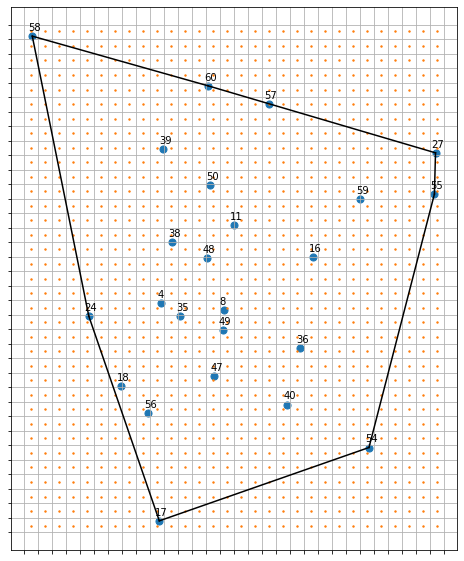

In [17]:
from scipy.spatial import ConvexHull

grid_shape = (35, 30)
fig, ax = plt.subplots()
fig.set_size_inches(8, 10)
# Interpolation points
istep = (irange[1] - irange[0] + 2 * offset) / grid_shape[0]
jstep = (jrange[1] - jrange[0] + 2 * offset) / grid_shape[1]
inew = np.linspace(irange[0] + offset - abs(istep)/2, irange[1] - offset + abs(istep)/2, grid_shape[0]) # <-- CAVEAT!
jnew = np.linspace(jrange[0] - offset + jstep/2, jrange[1] + offset - jstep/2, grid_shape[1])
I, J = np.meshgrid(inew, jnew, indexing='ij')
ax.scatter(df_locs.lng, df_locs.lat, s=50)
ax.scatter((J.ravel()), I.ravel(), s=2)
# Mesh-grid
inew = np.linspace(irange[0] + offset, irange[1] - offset, grid_shape[0] + 1)
jnew = np.linspace(jrange[0] - offset, jrange[1] + offset, grid_shape[1] + 1)
ax.set_xticks(jnew)
ax.set_yticks(inew)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid()
for s in range(df_st.shape[0]):
    ax.text(df_st.loc[s, 'LONGITUD'] - 0.002, df_st.loc[s, 'LATITUD'] + 0.002,
            df_st.loc[s, 'CODIGO_CORTO'], bbox=dict(facecolor='None', edgecolor='None', alpha=0.1))
# Compute and draw the convex hull
hull = ConvexHull(df_locs)
for simplex in hull.simplices:
    ax.plot(df_locs.iloc[simplex, 0], df_locs.iloc[simplex, 1], 'k-')
    #ax.plot(df_locs.iloc[hull.vertices,0], df_locs.iloc[hull.vertices,1], 'r--', lw=2)
    #ax.plot(df_locs.iloc[hull.vertices[0],0], df_locs.iloc[hull.vertices[0],1], 'ro')
plt.savefig('./graphs/madrid_convex_hull_labels.pdf', bbox_inches='tight')
plt.show()

Meteorological stations:

In [18]:
df_met = pd.DataFrame(np.array([[40.4516, -3.72416],
                               [40.4119, -3.67805],
                               [40.4666, -3.55555],
                               [40.3755, -3.78611],
                               [40.2994, -3.72222],
                               [40.4483, -3.81333],
                               [40.55, -3.61666],
                               [40.5613, -3.71194],
                               [40.3116, -3.49777],
                               [40.4886, -3.44361]]), columns=['lat', 'lng'],
                index=['C. Universitaria', 'Retiro', 'Barajas', 'Cuatro Vientos',
                       'Getafe', 'Pozuelo', 'San Sebastián', 'El Goloso', 'Arganda del Rey', 'Torrejón'])
df_met

,lat,lng
C. Universitaria,40.4516,-3.72416
Retiro,40.4119,-3.67805
Barajas,40.4666,-3.55555
Cuatro Vientos,40.3755,-3.78611
Getafe,40.2994,-3.72222
Pozuelo,40.4483,-3.81333
San Sebastián,40.5500,-3.61666
El Goloso,40.5613,-3.71194
Arganda del Rey,40.3116,-3.49777
Torrejón,40.4886,-3.44361


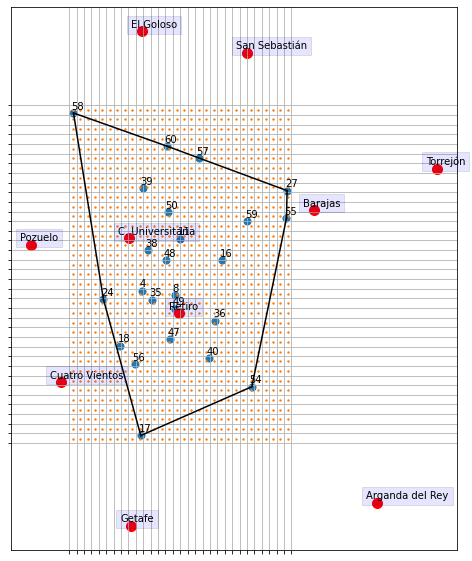

In [19]:
from scipy.spatial import ConvexHull

grid_shape = (35, 30)
fig, ax = plt.subplots()
fig.set_size_inches(8, 10)
# Interpolation points
istep = (irange[1] - irange[0] + 2 * offset) / grid_shape[0]
jstep = (jrange[1] - jrange[0] + 2 * offset) / grid_shape[1]
inew = np.linspace(irange[0] + offset - abs(istep)/2, irange[1] - offset + abs(istep)/2, grid_shape[0]) # <-- CAVEAT!
jnew = np.linspace(jrange[0] - offset + jstep/2, jrange[1] + offset - jstep/2, grid_shape[1])
I, J = np.meshgrid(inew, jnew, indexing='ij')
ax.scatter(df_locs.lng, df_locs.lat, s=50)
ax.scatter((J.ravel()), I.ravel(), s=2)
# Mesh-grid
inew = np.linspace(irange[0] + offset, irange[1] - offset, grid_shape[0] + 1)
jnew = np.linspace(jrange[0] - offset, jrange[1] + offset, grid_shape[1] + 1)
ax.set_xticks(jnew)
ax.set_yticks(inew)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid()
for s in range(df_st.shape[0]):
    ax.text(df_st.loc[s, 'LONGITUD'] - 0.002, df_st.loc[s, 'LATITUD'] + 0.002,
            df_st.loc[s, 'CODIGO_CORTO'], bbox=dict(facecolor='None', edgecolor='None', alpha=0.1))
# Compute and draw the convex hull
hull = ConvexHull(df_locs)
for simplex in hull.simplices:
    ax.plot(df_locs.iloc[simplex, 0], df_locs.iloc[simplex, 1], 'k-')
    #ax.plot(df_locs.iloc[hull.vertices,0], df_locs.iloc[hull.vertices,1], 'r--', lw=2)
    #ax.plot(df_locs.iloc[hull.vertices[0],0], df_locs.iloc[hull.vertices[0],1], 'ro')
ax.scatter(df_met.lng, df_met.lat, marker='o', c='r', s=100)
for s in range(df_met.shape[0]):
    ax.text(df_met.iloc[s].lng - 0.01, df_met.iloc[s].lat + 0.002,
            df_met.iloc[s].name, bbox=dict(facecolor='blue', alpha=0.1))
plt.savefig('./graphs/madrid_convex_hull_labels_met.pdf', bbox_inches='tight')
plt.show()

### Transfer

The final file will look like this:
```
01h_cxr_scaling_method_jacobi.h5 (file) (e.g. 01h_35x30_raw_linear_J0.0.h5)
|-- mesh-grid (carray) -> concentration: time + longitude + latitude
```

Parameters to be chosen:
  - time coverage: **2010 - 2022**
  - precision: **float32**
  - interpolation method: **NN or linear+NN**
  - fill method for linear+NN: **linear interp (inside convex hull) + NN interp (outside convex hull)**
  - indexing of meshgrid: **`ij` or `xy`** (we use `ij` to match `(lat, lng)`)
  - no/too few measurements: **see code**
  - scaling: **raw or standarization or normalization**

In [23]:
from scipy.interpolate import griddata

def interp_grid(arr, ab, A, B, method='nearest', fill_value=np.nan):
    '''
    ab : (lat, lng) or (lng, lat) of the available sensors.
    A : i or x coordinates of the mesh grid.
    B : j or y coordinates of the mesh grid.
    arr : Values used to interpolate.
    Note: It is important to check if A and B are built with indexing 'ij' or 'xy'.
    '''
    return griddata(ab, arr, (A, B), method=method, fill_value=fill_value)

def interp(arr, grids, id_t, i_empty, i_near_empty, method, s_codes, df_locs, A, B):
    '''
    - If mask.sum() == 0: take the previous (persistence)
    - If 1 <= mask.sum() <= 3: fix those mask.sum() sensors, take the previous for ~mask, and interpolate
    - If mask.sum() >= 4: interpolate normally
    ''' 
    mask = ~np.isnan(arr[id_t])
    if mask.sum() == 0:
        arr[id_t] = arr[id_t - 1]
        grids[id_t] = grids[id_t - 1]
        i_empty.append(id_t)
    else:
        aux = arr[id_t].copy()
        aux[~mask] = arr[id_t - 1, ~mask]
        mask = ~np.isnan(aux)
        if mask.sum() < 4: #if mask.sum() in [1, 2, 3]:
            i_near_empty.append(id_t)
            method = 'nearest'
        grids[id_t] = interp_grid(aux[mask].T, df_locs.loc[s_codes[mask]].values,
                                  A, B, method=method)
        if method == 'linear':
            mask_g = ~np.isnan(grids[id_t])
            grids[id_t] = interp_grid(grids[id_t, mask_g].T, np.stack([A[mask_g], B[mask_g]], axis=1),
                                      A, B, method='nearest')
    return arr, grids, i_empty, i_near_empty

def stand_arr(arr):
    mean = np.nanmean(arr)
    std = np.nanstd(arr)
    arr = (arr - mean) / std
    return arr, mean, std

def norm_arr(arr):
    mini = np.nanmax(arr)
    maxi = np.nanmin(arr)
    arr = (arr - mini) / (maxi - mini)
    return arr, mini, maxi

def transfer_grid(in_path, out_path, df_locs, grid_shape, offset=0.004,
                  method='nearest', scaling='raw', indexing='ij'):
    # Parameters for the hdf5 file
    filters = tb.Filters(complib='blosc:lz4hc', complevel=9)
    dtype = tb.Float32Atom()
    # Prepare coordinates for interpolation
    irange = (df_locs.lat.max(), df_locs.lat.min()) # <-- CAVEAT! Since we use ij, latitude decreases as i increases
    jrange = (df_locs.lng.min(), df_locs.lng.max())
    istep = (irange[1] - irange[0] + 2 * offset) / grid_shape[0] # <-- CAVEAT! Therefore, istep is negative
    jstep = (jrange[1] - jrange[0] + 2 * offset) / grid_shape[1]
    inew = np.linspace(irange[0] + offset - abs(istep)/2, irange[1] - offset + abs(istep)/2, grid_shape[0]) # <-- CAVEAT!
    jnew = np.linspace(jrange[0] - offset + jstep/2, jrange[1] + offset - jstep/2, grid_shape[1])
    I, J = np.meshgrid(inew, jnew, indexing='ij')
    # Auxiliary dictionaries:
    if scaling == 'stand':
        vc_mean_map = OrderedDict()
        vc_std_map = OrderedDict()
    elif scaling == 'norm': 
        vc_min_map = OrderedDict()
        vc_max_map = OrderedDict()
    tic = time.time()
    with tb.open_file(in_path, mode='r') as h5_in, \
         tb.open_file(out_path, mode='a', filters=filters) as h5_out, \
         warnings.catch_warnings() as w:
        warnings.simplefilter('ignore', tb.NaturalNameWarning)
        # We name vc_map/vc_sc_map differently to avoid overlapping the variable name
        vc_map_in = h5_in.root._v_attrs['vc_map']
        vc_sc_map_in = h5_in.root._v_attrs['vc_sc_map']
        grids_l = []
        i_emptys, i_near_emptys = OrderedDict(), OrderedDict()
        for id_v, vc in enumerate(vc_map_in.keys()):
            print('{:02}. Working on {}...'.format(id_v, vc_map_in[vc]), end='\t')
            # Load input array (time x sensor) for the current variable (excluding time_since_epoch)
            arr_v = h5_in.root['/v{}'.format(vc)][:, 1:]
            if scaling == 'raw':
                pass
            elif scaling == 'stand':
                arr_v, vc_mean_map[vc], vc_std_map[vc] = stand_arr(arr_v)
            elif scaling == 'norm':
                arr_v, vc_min_map[vc], vc_max_map[vc] = norm_arr(arr_v)
            # Load sensor codes for the current variable (excluding time_since_epoch)
            s_codes = np.array(h5_in.root['/v{}'.format(vc)]._v_attrs['columns'][1:])
            # Create empty 3D array (time x grid_shape)
            grids = np.empty((arr_v.shape[0], *grid_shape), dtype=np.float32)
            i_empty, i_near_empty = [], []
            for id_t in range(arr_v.shape[0]): # Interpolate gaps (watch the axes order!) for each instant
                arr_v, grids, i_empty, i_near_empty = interp(arr_v, grids, id_t, i_empty, i_near_empty,
                                                             method, s_codes, df_locs, I, J)
            print('no sensors: {} instants\t \tfew sensors: {} instants'.format(len(i_empty), len(i_near_empty)))
            # Add current grid to the list that gathers them, also the lists of [near]emptys
            grids_l.append(grids)
            i_emptys[vc], i_near_emptys[vc] = i_empty, i_near_empty
        # Transfer into new hdf5 file
        node = h5_out.create_carray(obj=np.stack(grids_l, axis=-1), atom=dtype,
                                    createparents=True, where='/', name='gases')
        # Add and copy meta:
        new_meta = {'grid_shape': grid_shape, 'indexing': indexing, 'ij': df_locs.values, 'IJ': (I, J),
                    'i_emptys': i_emptys, 'i_near_emptys': i_near_emptys}
        if scaling == 'stand':
            new_meta['vc_mean_map'] = vc_mean_map
            new_meta['vc_std_map'] = vc_std_map
        elif scaling == 'norm':
            new_meta['vc_min_map'] = vc_min_map
            new_meta['vc_max_map'] = vc_max_map
        copy_meta(h5_in, h5_out,
                  ['sc_map', 'sn_map', 'vc_map', 'vn_map', 'vc_sc_map', 'time_resolution',
                   'gases_in_mug', 'gases_in_mg', 'vc_map_pretty', 'initial_dt'],
                  new_meta)
    return 'It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic)))

In [35]:
#!rm "../data/madrid/clean/01h_35x30_raw_nearest_J0.0.h5"

In [47]:
#!rm "../data/madrid/clean/01h_35x30_raw_linear_J0.0.h5"

In [24]:
methods = ['nearest', 'linear']
scalings = ['raw', 'stand', 'norm']

grid_shape = (35, 30)
jacobi = 0.
in_path = '../data/madrid/clean/01h_flat_raw.h5'

for method in methods:
    for scaling in scalings:
        print('\nStarting with {}-{}...'.format(scaling, method))
        out_path = '../data/madrid/clean/01h_35x30_{}_{}_J{:0.2}.h5'.format(scaling, method, jacobi)
        t = transfer_grid(in_path, out_path, df_locs[['lat', 'lng']],
                      grid_shape=grid_shape, method=method, scaling=scaling)
        print(t)


Starting with raw-nearest...
00. Working on SO2...	no sensors: 13 instants	 	few sensors: 764 instants
01. Working on CO...	no sensors: 13 instants	 	few sensors: 183 instants
02. Working on NO...	no sensors: 13 instants	 	few sensors: 0 instants
03. Working on NO2...	no sensors: 13 instants	 	few sensors: 0 instants
04. Working on PM25...	no sensors: 13 instants	 	few sensors: 576 instants
05. Working on PM10...	no sensors: 15 instants	 	few sensors: 0 instants
06. Working on NOx...	no sensors: 13 instants	 	few sensors: 0 instants
07. Working on O3...	no sensors: 13 instants	 	few sensors: 0 instants
08. Working on TOL...	no sensors: 13 instants	 	few sensors: 173 instants
09. Working on BEN...	no sensors: 13 instants	 	few sensors: 100 instants
10. Working on EBE...	no sensors: 13 instants	 	few sensors: 135 instants
It took 00:18:47 in total

Starting with stand-nearest...
00. Working on SO2...	no sensors: 13 instants	 	few sensors: 764 instants
01. Working on CO...	no sensors: 13

---

### Sanity checks

- `i_emptys`: number of times there are no sensors active.
- `i_near_emptys`: number of times there are only 1, 2 or 3 sensors active.

In [25]:
path = '../data/madrid/clean/01h_35x30_raw_nearest_J0.0.h5'
with tb.open_file(path, mode='r') as h5_in:
    grid = h5_in.root.gases[:]
    i_emptys = h5_in.root._v_attrs['i_emptys']
    i_near_emptys = h5_in.root._v_attrs['i_near_emptys']

Number of instants: 108049 

gas	idxmin	idxmax
01	2066	107234
06	2066	107234
07	2066	107234
08	2066	107234
09	2066	107234
10	2066	107234
12	2066	107234
14	2066	107234
20	2066	107234
30	2066	107234
35	2066	107234


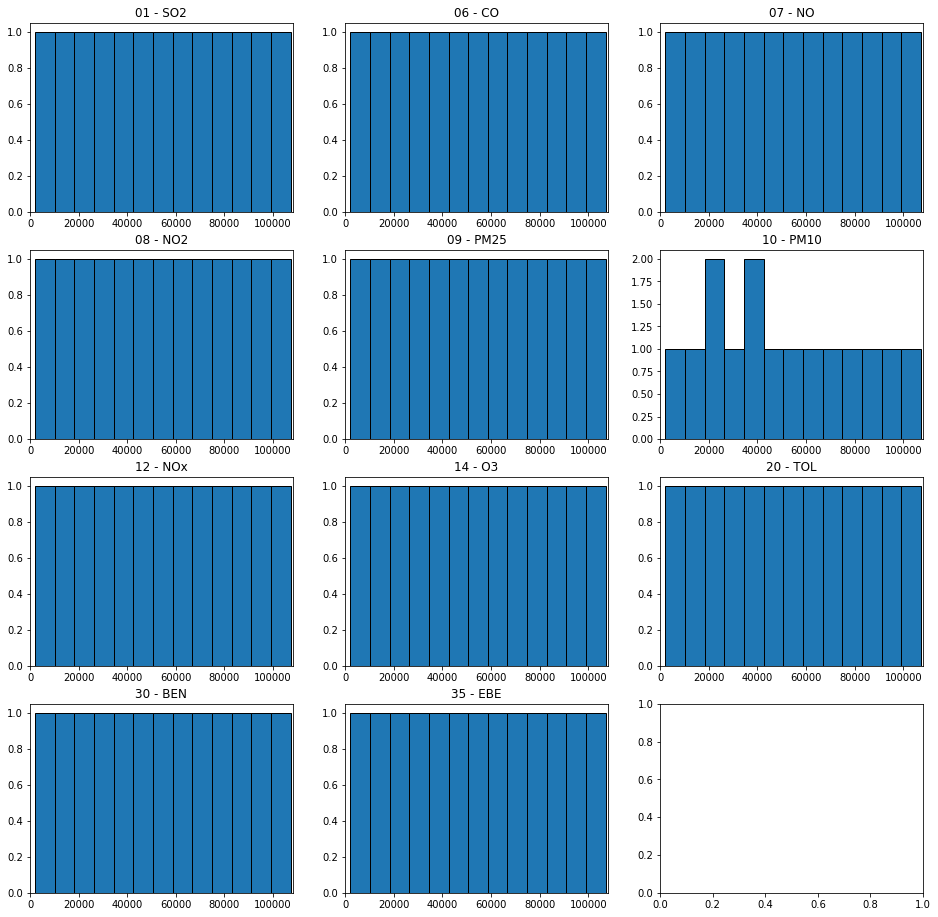

In [26]:
print('Number of instants:', grid.shape[0], '\n')
print('gas\tidxmin\tidxmax')
fig, axs = plt.subplots(4, 3)
axs = axs.ravel()
fig.set_size_inches(16, 16)
for idx, (k, v) in enumerate(i_emptys.items()):
    axs[idx].hist(i_emptys[k], edgecolor='k', bins=13)
    axs[idx].set_title(k + ' - ' + vc_map[k])
    axs[idx].set_xlim(0, grid.shape[0]+1)
    print('{}\t{}\t{}'.format(k, min(i_emptys[k]), max(i_emptys[k])))

Note:
- Index 80000 corresponds to 16/02/2019
- Index 90000 corresponds to 8/04/2020
- Index 90000 corresponds to 29/05/2021

Number of instants: 108049 

code	gas	idxmin	idxmax
01	SO2	101816	107441
06	CO	97018	107460
07	NO	-	-
08	NO2	-	-
09	PM25	178	83777
10	PM10	-	-
12	NOx	-	-
14	O3	-	-
20	TOL	14260	106334
30	BEN	20640	106777
35	EBE	20640	105839


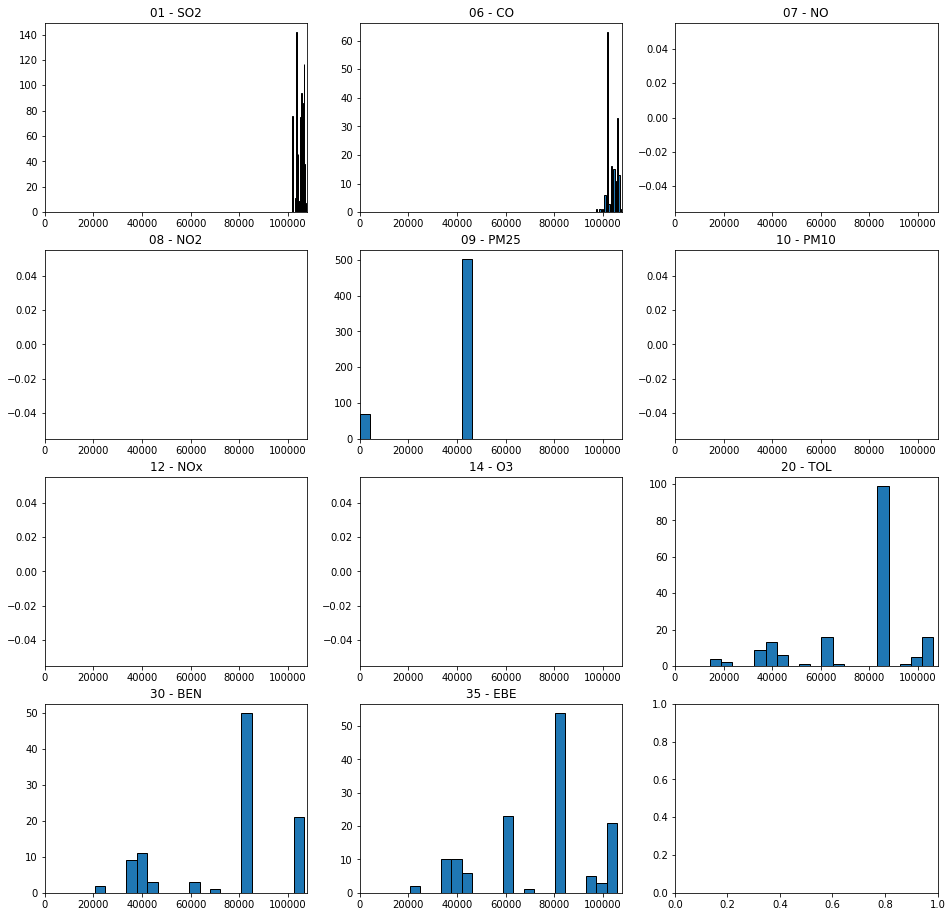

In [27]:
print('Number of instants:', grid.shape[0], '\n')
print('code\tgas\tidxmin\tidxmax')
fig, axs = plt.subplots(4, 3)
axs = axs.ravel()
fig.set_size_inches(16, 16)
for idx, (k, v) in enumerate(i_near_emptys.items()):
    axs[idx].hist(i_near_emptys[k], edgecolor='k', bins=20)
    axs[idx].set_title(k + ' - ' + vc_map[k])
    axs[idx].set_xlim(0, grid.shape[0]+1)
    print('{}\t{}\t{}\t{}'.format(k, vc_map[k],
                                  min(i_near_emptys[k], default='-'), max(i_near_emptys[k], default='-')))

### Jacobi transform

In [1741]:
def jacobi(arr, blacklist=[], eps=0.01, show=False):
    M, N = arr.shape
    w = arr.copy()
    eps, diff = eps, eps
    ite, ite_print = 0, 1
    tic = time.time()
    while eps <= diff:
        # Save the old solution in u
        u = w.copy()
        diff = 0.0
        for i in range(1, M - 1):
            for j in range(1, N - 1):
                if (j, i) not in blacklist:
                    w[i, j] = (u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1] ) * 0.25
                aux = abs(w[i, j] - u[i, j])
                if diff < aux:
                    diff = aux
        ite += 1
        if ite == ite_print and show:
            print(ite, '\t', diff)
            ite_print = 2 * ite_print
    
    if show:
        print('\nIt took {:0.05}s in total (n_ite = {})'.format(time.time() - tic, ite))
        plt.imshow(w, origin='lower')
        plt.show()
    return w

def jacobi_transform(in_path, out_path, df_locs):
    xid = np.argmin(np.abs(np.array([xi - xnew for xi in df_locs.lng])), axis=1)
    yid = np.argmin(np.abs(np.array([yi - ynew for yi in df_locs.lat])), axis=1)
    blacklist = list(zip(xid, yid))
    
    # Parameters for the hdf5 file
    filters = tb.Filters(complib='blosc:lz4hc', complevel=9)
    tic = time.time()
    with tb.open_file(in_path, mode='r') as h5_in, \
         tb.open_file(out_path, mode='a', filters=filters) as h5_out, \
         warnings.catch_warnings() as w:
        warnings.simplefilter('ignore', tb.NaturalNameWarning)
        dtype = tb.Float32Atom()
        arr = h5_in.root.gases[:]
        arr_out = np.empty(arr.shape, dtype=np.float32)
        for id_g in range(arr.shape[-1]):
            print('Working on gas {}...'.format(id_g))
            arr_g = arr[:, :, :, id_g]
            m = arr_g.max() / 10
            for id_t in range(arr.shape[0]):
                arr_out[id_t, :, :, id_g] = jacobi(arr_g[id_t], blacklist, eps=m)
        # Transfer into new hdf5 file
        node = h5_out.create_carray(obj=arr_out, createparents=True, atom=dtype,
                                      where='/', name='gases')
        # Propagate meta
        node_old = h5_in.root
        node = h5_out.root
        node._v_attrs['s_map'] = node_old._v_attrs['s_map']
        node._v_attrs['sc_map'] = node_old._v_attrs['sc_map']
        node._v_attrs['g_map'] = node_old._v_attrs['g_map']
        node._v_attrs['gc_map'] = node_old._v_attrs['gc_map']
        node._v_attrs['time_resolution'] = node_old._v_attrs['time_resolution']
        node._v_attrs['grid_dimensions'] = node_old._v_attrs['grid_dimensions']
        node._v_attrs['gases_in_mug'] = node_old._v_attrs['gases_in_mug']
        node._v_attrs['gases_in_mg'] = node_old._v_attrs['gases_in_mg']
    return 'It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic)))

Final dataset shape is: `(102241, 35, 30, 11) -> (time, lat, long, gas)`

In [1742]:
!rm ../data/madrid/clean/01h_30x35_rawComb_nnJac.h5

rm: cannot remove '../data/madrid/clean/01h_30x35_rawComb_nnJac.h5': No such file or directory


In [1743]:
in_path = '../data/madrid/clean/01h_30x35_rawComb_nn.h5'
out_path = '../data/madrid/clean/01h_30x35_rawComb_nnJac.h5'
jacobi_transform(in_path, out_path, df_locs)

Working on gas 0...
Working on gas 1...
Working on gas 2...
Working on gas 3...
Working on gas 4...
Working on gas 5...
Working on gas 6...
Working on gas 7...
Working on gas 8...
Working on gas 9...
Working on gas 10...


'It took 02:56:25 in total'

### Sanity checks and decisions

In [1114]:
def read_arr(n, g, dset='30x35_raw', ret_cols=False):
    in_path = '../data/madrid/clean/01h_{}_{}.h5'.format(dset, n)
    with tb.open_file(in_path, mode='r') as h5:
        n = '/g{:02}'.format(g)
        if n in h5.root and ret_cols:
            return h5.root[n][:], h5.root[n]._v_attrs['columns']
        elif n in h5.root:
            return h5.root[n][:]

def compare_dsets(f1, f2, g_exc=[]):
    fig, axs = plt.subplots(6, 2)
    fig.set_size_inches(20, 30)
    axs = axs.ravel()
    print('Maximum differences between {} and {}:\n'.format(f1, f2))
    idx = 0

    for g in gc_map.keys():
        if g in g_exc:
            continue
        arr1 = read_arr(f1, g)
        arr2 = read_arr(f2, g)
        maxi, i_maxi = 0, 0
        differences = np.empty_like(arr1)
        for i in range(arr1.shape[0]):
            diff = arr1[i] - arr2[i]
            if diff.max() > maxi:
                maxi = diff.max()
                i_maxi = i
            differences[i] = diff
        print('For {}: {} (idx {})'.format(gc_map[g], maxi, i_maxi))
        axs[idx].hist(differences.ravel(), edgecolor='k', bins=50)
        axs[idx].set_title(gc_map[g])
        idx += 1
    plt.show()

#### Float dtypes

Baseline dataset: `fillna=0, method='linear'`   
Comparison between using different data types:
- `float16`: 591MB.
- `float32`: 1.27GB.
- `float64`: 2.85GB.

Maximum differences between float16 and float32:

For NO2: 0.12493896484375 (idx 43915)
For SO2: 0.0311431884765625 (idx 63116)
For CO: 0.0032129287719726562 (idx 34389)
For PM10: 0.12493896484375 (idx 53845)
For PM2_5: 0.0601043701171875 (idx 53848)
For O3: 0.0625 (idx 2415)
For EBE: 0.01531219482421875 (idx 77194)
For NO: 0.4127197265625 (idx 51380)
For NOx: 0.499755859375 (idx 7387)
For TOL: 0.04022216796875 (idx 82395)
For BEN: 0.0067539215087890625 (idx 68541)


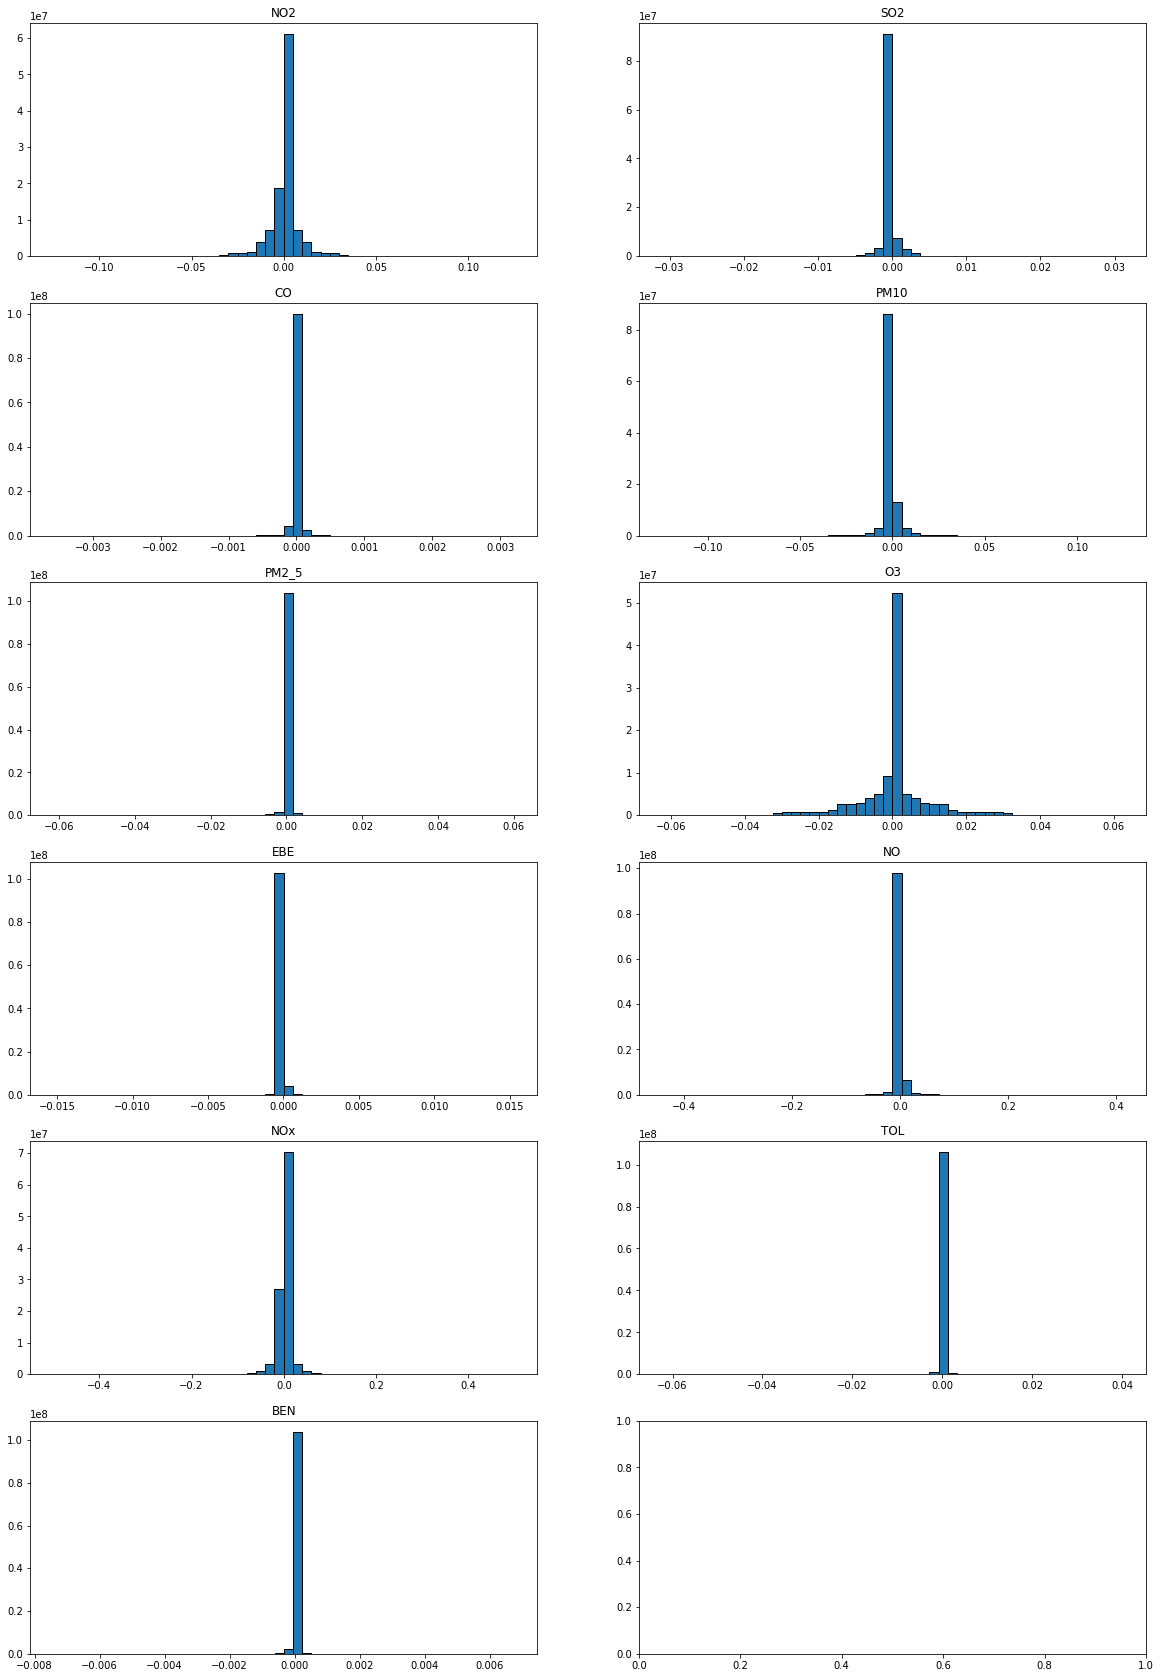

In [665]:
f1, f2 = 'float16', 'float32'
g_exc = [42, 43, 44]
compare_dsets(f1, f2, g_exc)

Maximum differences between float32 and float64:

For NO2: 1.5255860489560291e-05 (idx 43987)
For SO2: 3.7965539121387337e-06 (idx 1748)
For CO: 3.309806597684428e-07 (idx 34389)
For PM10: 1.5252935099852039e-05 (idx 53846)
For PM2_5: 6.948927051553255e-06 (idx 53847)
For O3: 7.629335414094385e-06 (idx 40458)
For EBE: 1.8834188608707336e-06 (idx 77194)
For NO: 5.2286566415205016e-05 (idx 9645)
For NOx: 6.103202531448915e-05 (idx 78234)
For TOL: 4.3046849214078975e-06 (idx 82395)
For BEN: 9.047820554997088e-07 (idx 68541)


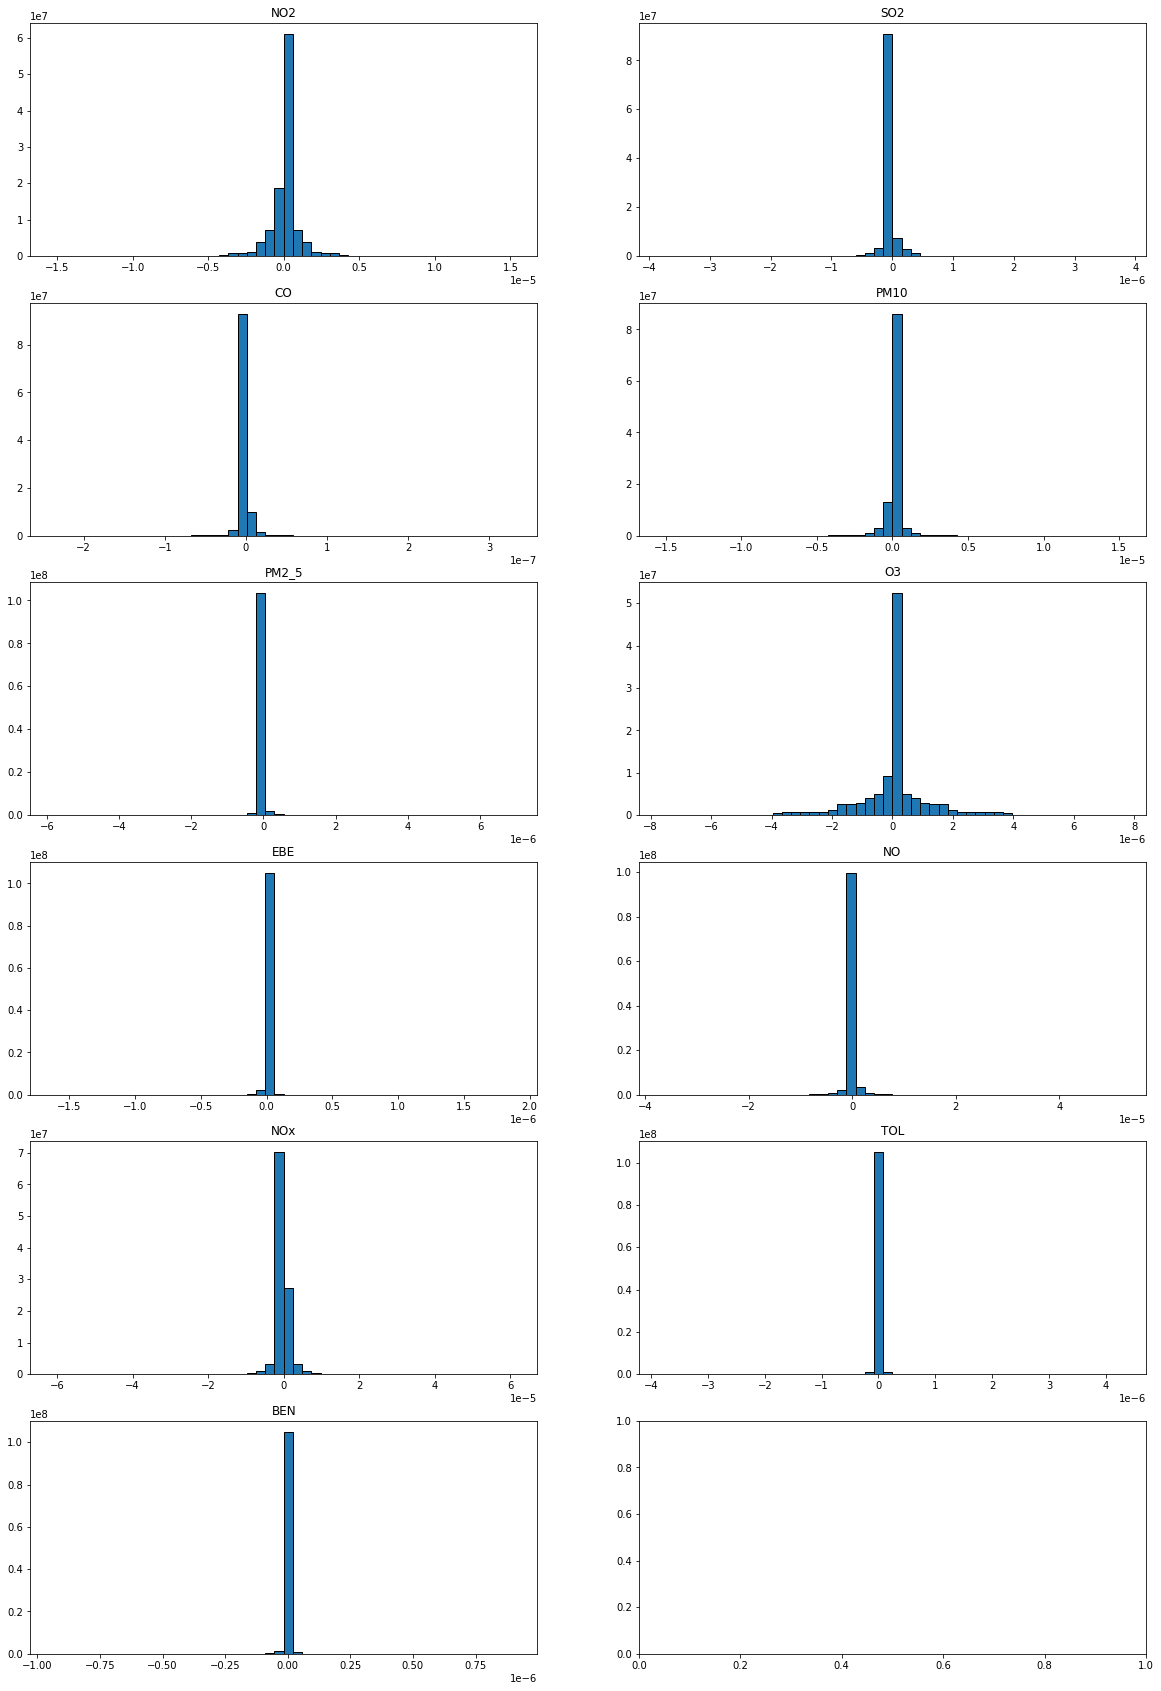

In [666]:
f1, f2 = 'float32', 'float64'
g_exc = [42, 43, 44]
compare_dsets(f1, f2, g_exc)

#### Interp vs fill + interp

Here we compare differences between using just interpolation or filling with `df.fillna(method=ffill)` + interpolation.  
**Note**: In this case, there is no need to compute average mesh-grids for the time change of March, as it can be seen below.

In [709]:
def transfer_grid_fill(in_path, out_path, df, g_exc=[], grid_shape=(30, 35),
                  offset=0.002, start_date='1-1-2010', end_date='31/08/2021'):
    # Parameters for the hdf5 file
    filters = tb.Filters(complib='blosc:lz4hc', complevel=9)
    dtype = tb.Float32Atom()
    # Prepare coordinates for interpolation
    xrange = (df.lng.min(), df.lng.max())
    yrange = (df.lat.min(), df.lat.max())
    xstep = (xrange[1] - xrange[0] + 2 * offset) / grid_shape[0]
    ystep = (yrange[1] - yrange[0] + 2 * offset) / grid_shape[1]
    xnew = np.linspace(xrange[0] - offset + xstep/2, xrange[1] + offset - xstep/2, grid_shape[0])
    ynew = np.linspace(yrange[0] - offset + ystep/2, yrange[1] + offset - ystep/2, grid_shape[1])
    X, Y = np.meshgrid(xnew, ynew, indexing='ij')
    tic = time.time()
    with tb.open_file(in_path, mode='r') as h5_in, \
         tb.open_file(out_path, mode='a', filters=filters) as h5_out, \
         warnings.catch_warnings() as w:
        warnings.simplefilter('ignore', tb.NaturalNameWarning)
        for idx, g in enumerate([12]):
            if g in g_exc:
                continue
            print('Working on {}...'.format(gc_map[g]))
            df_g = pd.DataFrame(index=pd.date_range(start_date, end_date, freq='1h').astype('int64') // 1e9)
            for st in sc_map.keys():
                n = '/s{:02}/g{:02}'.format(st, g)
                if n not in h5_in.root:
                    continue
                aux = h5_in.root[n][:]
                aux = pd.DataFrame(data=aux[:, 1], index=aux[:, 0].astype(int), columns=[st])
                df_g = pd.merge(df_g, aux, left_index=True, right_index=True, how='left')
                df_g.fillna(method='ffill', inplace=True)
            # Interpolate gaps (watch the axes order!)
            grid = np.empty((df_g.shape[0], *grid_shape[::-1]), dtype=np.float32)
            i_nan = []
            for i, t in enumerate(df_g.index):
                mask = ~df_g.loc[t].isna()
                if mask.sum() >= 4:
                    grid[i] = interp_grid(df_g.loc[t, mask].values.T, df.loc[df_g.columns[mask]].values, X, Y,
                                  method='linear', fill_value=0).transpose((1, 0))
                else:
                    i_nan.append(i) 
            for i in i_nan:
                grid[i] = (grid[i-1] + grid[i+1]) / 2
            print('Filled with avg grid {} times'.format(len(i_nan)))
            # Transfer into new hdf5 file
            node = h5_out.create_carray(obj=grid, createparents=True, atom=dtype,
                                          where='/', name='g{:02}'.format(g))
        # Add meta: column names
        node = h5_out.root
        node._v_attrs['s_map'] = s_map
        node._v_attrs['sc_map'] = sc_map
        node._v_attrs['g_map'] = g_map
        node._v_attrs['gc_map'] = gc_map
        node._v_attrs['time_resolution'] = '01h'
        node._v_attrs['grid_dimensions'] = '{}x{}'.format(*grid_shape)
        node._v_attrs['gases_in_mug'] = [1, 7, 8, 9, 10, 12, 14, 20, 30, 35]
        node._v_attrs['gases_in_mg'] = [6, 42, 43, 44]
    return 'It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic)))

In [704]:
in_path = '../data/madrid/clean/01h_flat_raw.h5'
out_path = '../data/madrid/clean/01h_30x35_raw_ffill.h5'
a = transfer_grid_fill(in_path, out_path, df_locs, g_exc=[42, 43, 44], grid_shape=(30, 35),
              start_date='1-1-2010', end_date='31/08/2021')

Working on NO2...
Filled with avg grid 0 times
Working on SO2...
Filled with avg grid 0 times
Working on CO...
Filled with avg grid 0 times
Working on PM10...
Filled with avg grid 0 times
Working on PM2_5...
Filled with avg grid 0 times
Working on O3...
Filled with avg grid 0 times
Working on EBE...
Filled with avg grid 0 times
Working on NO...
Filled with avg grid 0 times
Working on NOx...
Filled with avg grid 0 times
Working on TOL...
Filled with avg grid 0 times
Working on BEN...
Filled with avg grid 0 times

It took 00:26:08 in total



Maximum differences between ffill and float32:

For NO2: 297.94775390625 (idx 7197)
For SO2: 68.74321746826172 (idx 62457)
For CO: 2.5266268253326416 (idx 61101)
For PM10: 259.9864196777344 (idx 101034)
For PM2_5: 131.35728454589844 (idx 43822)
For O3: 213.233154296875 (idx 30834)
For EBE: 20.31011390686035 (idx 84276)
For NO: 730.0194702148438 (idx 7197)
For NOx: 1417.6942138671875 (idx 7197)
For TOL: 62.84514617919922 (idx 42094)
For BEN: 16.838396072387695 (idx 42332)


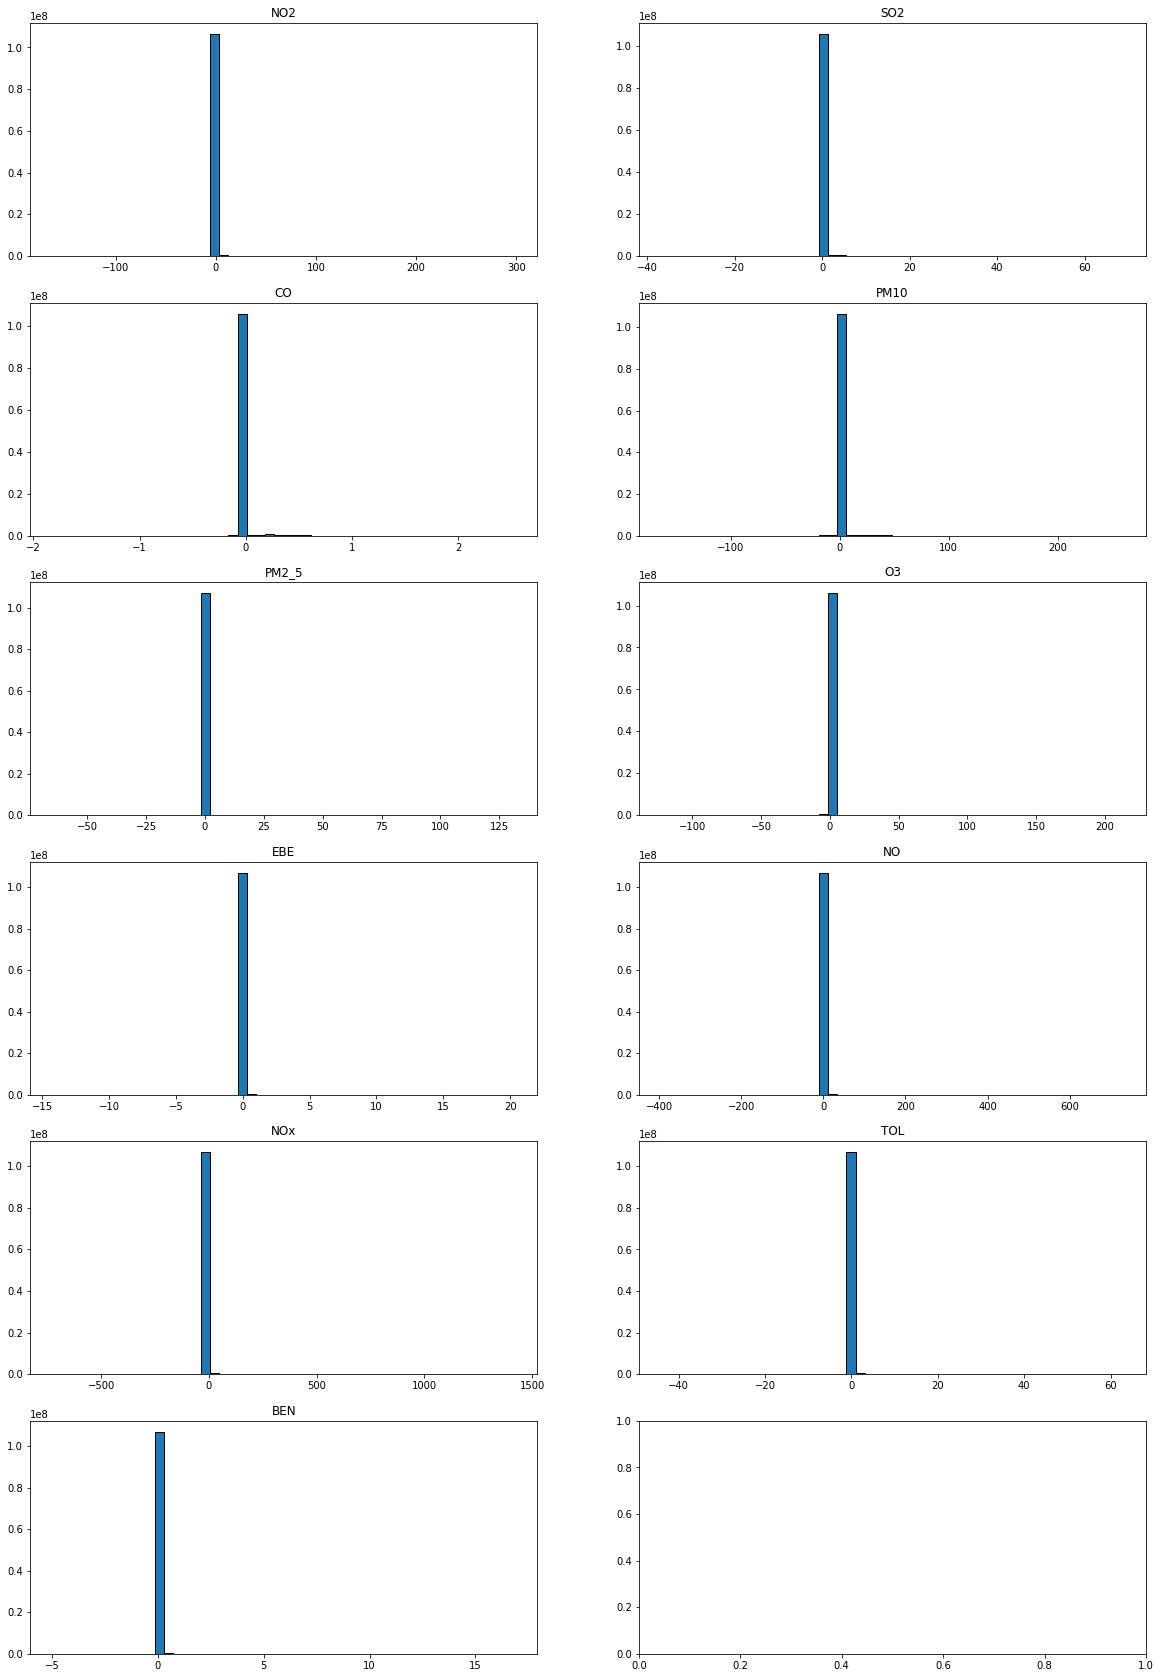

In [689]:
f1, f2 = 'ffill', 'float32'
g_exc = [42, 43, 44]
compare_dsets(f1, f2, g_exc)

Lets check NOx closer:

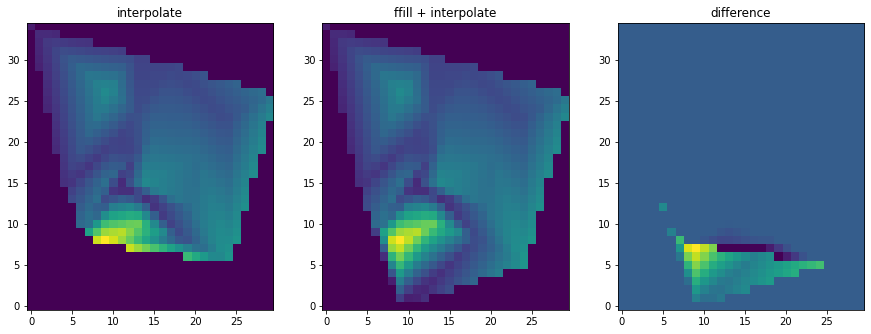

In [842]:
f32 = read_arr(n='float32', g=12)
ffill = read_arr(n='ffill', g=12)

fig, axs = plt.subplots(1, 3)
fig.set_size_inches(15, 8)
axs[0].imshow(f32[7197], origin='lower')
axs[0].set_title('interpolate')
axs[1].imshow(ffill[7197], origin='lower')
axs[1].set_title('ffill + interpolate')
axs[2].imshow(ffill[7197] - f32[7197], origin='lower')
axs[2].set_title('difference')
plt.show()

In this hour, sensor 17 lacks the measurement. Therefore, there is a big difference between interp and fill + interp.  
Similar situation for PM10:

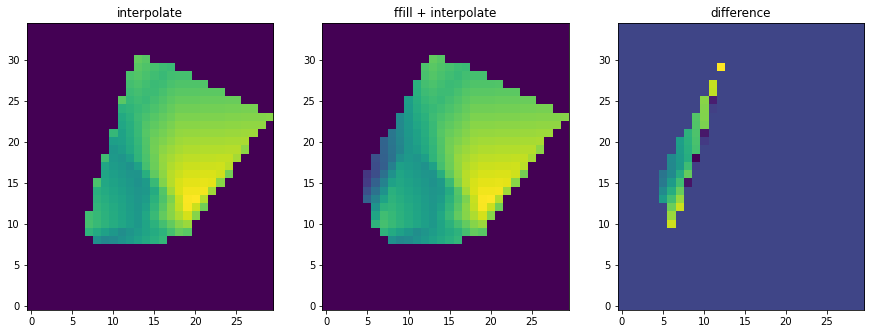

In [845]:
f32 = read_arr(n='float32', g=10)
ffill = read_arr(n='ffill', g=10)

idx = 101034
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(15, 8)
axs[0].imshow(f32[idx], origin='lower')
axs[0].set_title('interpolate')
axs[1].imshow(ffill[idx], origin='lower')
axs[1].set_title('ffill + interpolate')
axs[2].imshow(ffill[idx] - f32[idx], origin='lower')
axs[2].set_title('difference')
plt.show()

#### Outside of the convex hull

It does not make sense to fill with zeros the cells that are outside of the convex hull. It could make sense using: min, avg or NN.  
For instance, the following graph shows a linear interpolation inside the convex hull and NN outside of it.

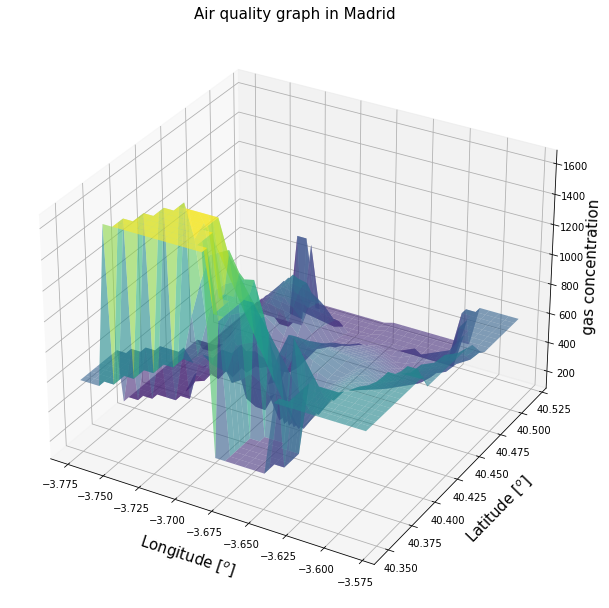

In [1147]:
ftest = read_arr(n='linearNN', g=12)

fig = plt.figure()
ax = p3.Axes3D(fig)
fig.set_size_inches(10, 8)
ax.set_xlabel(xlabel='Longitude [$^o$]', fontsize=15, labelpad=12)
ax.set_ylabel(ylabel='Latitude [$^o$]', fontsize=15, labelpad=12)
ax.set_zlabel(zlabel='gas concentration', fontsize=15)

instant = 7197

ax.set_title('Air quality graph in Madrid', fontsize=15)
ax.plot_surface(X, Y, ftest[instant].T, cmap='viridis', alpha=0.6)

plt.show()

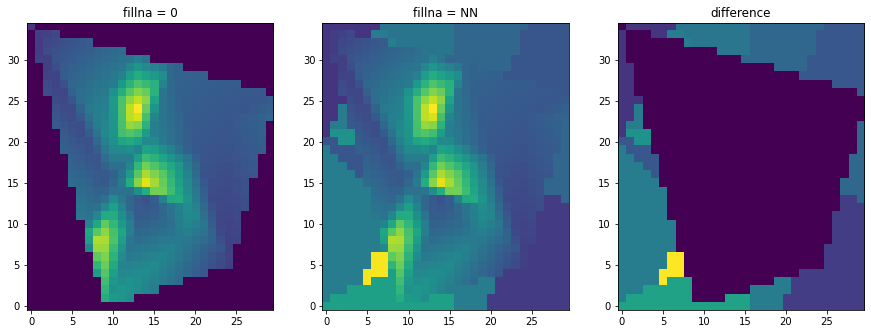

In [857]:
f32 = read_arr(n='float32', g=12)
ftest = read_arr(n='linearNN', g=12)

idx = 101034 # 7197
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(15, 8)
axs[0].imshow(f32[idx], origin='lower')
axs[0].set_title('fillna = 0')
axs[1].imshow(ftest[idx], origin='lower', vmin=0)
axs[1].set_title('fillna = NN')
axs[2].imshow(ftest[idx] - f32[idx], origin='lower')
axs[2].set_title('difference')
plt.show()

#### Linear vs cubic

In [1401]:
n = 'linearNN'

df = pd.DataFrame(columns=['min', 'mean', 'median', 'max', 'std'])
df.index.set_names(['code'], inplace=True)

for g in gc_map.keys():
    if g in g_exc:
        continue
    arr = read_arr(n=n, g=g)
    df.loc[g, 'min'] = arr.min()
    df.loc[g, 'mean'] = arr.mean()
    df.loc[g, 'median'] = np.median(arr)
    df.loc[g, 'max'] = arr.max()
    df.loc[g, 'std'] = arr.std()
df.reset_index(inplace=True)
df['gas'] = df.code.replace(c_map)
df = df[['code', 'gas', 'min', 'mean', 'median', 'max', 'std']]
df.to_csv('./results/madrid_gases_linearNN.csv', index=False)
df

,code,gas,min,mean,median,max,std
0,8,NO2,1.0,34.467937,26.175777,410.461090,28.192802
1,1,SO2,0.0,6.523215,5.937453,104.000000,4.796577
2,6,CO,0.1,0.333715,0.300000,10.400000,0.234340
3,10,PM10,0.0,19.755812,15.227196,451.000000,17.107113
4,9,PM2_5,0.0,10.644725,9.000000,215.000000,7.996836
5,14,O3,0.6,50.742943,50.200001,235.699997,32.996605
6,35,EBE,0.0,0.644024,0.300000,60.799999,0.986397
7,7,NO,0.0,18.754347,4.741298,1074.798462,42.118286
8,12,NOx,2.0,63.191799,34.052132,2052.103271,87.479401
9,20,TOL,0.1,2.680659,1.600000,149.600006,3.448265


In [1402]:
n = 'cubicNN'

df = pd.DataFrame(columns=['min', 'mean', 'median', 'max', 'std'])
df.index.set_names(['code'], inplace=True)

for g in gc_map.keys():
    if g in g_exc:
        continue
    arr = read_arr(n=n, g=g)
    df.loc[g, 'min'] = arr.min()
    df.loc[g, 'mean'] = arr.mean()
    df.loc[g, 'median'] = np.median(arr)
    df.loc[g, 'max'] = arr.max()
    df.loc[g, 'std'] = arr.std()
df.reset_index(inplace=True)
df['gas'] = df.code.replace(c_map)
df = df[['code', 'gas', 'min', 'mean', 'median', 'max', 'std']]
df.to_csv('./results/madrid_gases_cubicNN.csv', index=False)
df

,code,gas,min,mean,median,max,std
0,8,NO2,-99.712082,35.332985,27.000000,541.333313,29.719852
1,1,SO2,-39.097271,6.587877,5.891403,120.992035,5.047739
2,6,CO,-1.766740,0.334878,0.300000,11.490174,0.239494
3,10,PM10,-73.926376,19.863228,15.385179,476.790985,17.369867
4,9,PM2_5,-14.306473,10.646134,9.000000,215.000000,8.013790
5,14,O3,-158.518433,51.007339,50.259998,295.284210,33.985012
6,35,EBE,-21.458782,0.649019,0.300000,76.371376,1.001698
7,7,NO,-322.616058,19.738125,4.789567,1506.212524,45.839005
8,12,NOx,-498.057861,65.565979,35.000000,2850.902832,94.327156
9,20,TOL,-55.198616,2.701762,1.600000,158.315689,3.476386


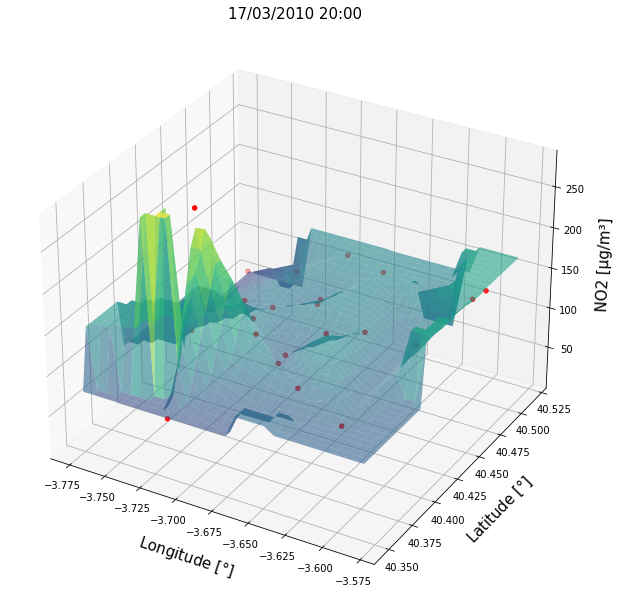

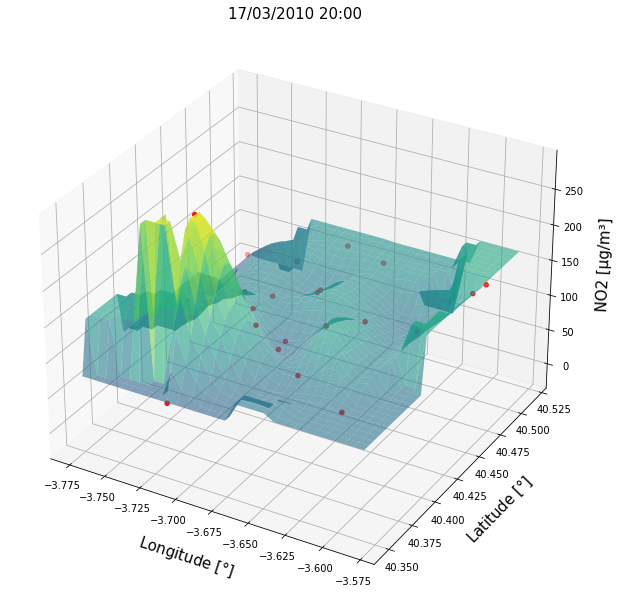

In [1600]:
date = '15/03/2010'
n_days = 7
g = 8
n = 'linearNN'
frame = 68
plot3d(date, n_days, g, n, frame)

n = 'cubicNN'
plot3d(date, n_days, g, n, frame)

#### NN vs linearNN

We inspect the 17/03/2010 at 20:00, because there is a peak.

In [1335]:
instant = 2 * 24 + 20
instant

68

Using linear (inside the convex hull) and nearest neighbors (outside):

In [1395]:
date = '15/03/2010'
n_days = 7
g = 8
n = 'linearNN'

idx = (pd.DatetimeIndex([date], dayfirst=True) - pd.DatetimeIndex(['1/1/2010'], dayfirst=True)).days.values[0] * 24
times = pd.date_range(date, periods=n_days * 24, freq='1h')
times = times.format(date_format='%d/%m/%Y %H:%M')
arr = read_arr(n=n, g=g)[idx:idx+n_days*24]

idx = (pd.DatetimeIndex([date], dayfirst=True) - pd.DatetimeIndex(['1/1/2001'], dayfirst=True)).days.values[0] * 24
sca, cols = read_arr(dset='flat', n='rawComb', g=g, ret_cols=True)
sca = sca[idx:idx+n_days*24]

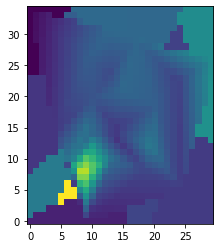

In [1396]:
plt.imshow(arr[instant], origin='lower')

There seems to be a weird depression around (7, 7), lets take a closer look:

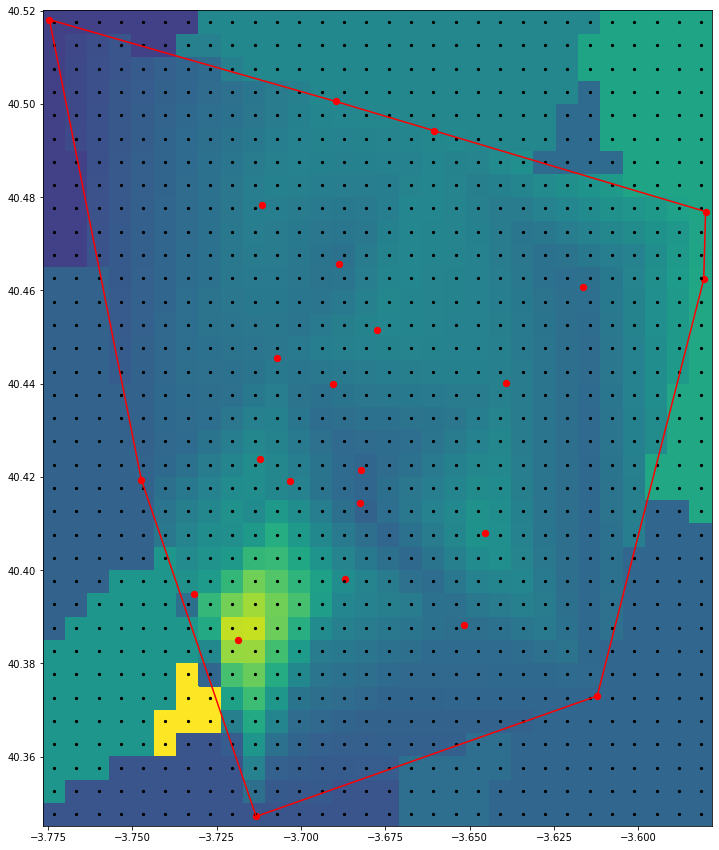

In [1397]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 15)
ax.pcolor(X, Y, arr[instant].T, vmin=0, vmax=288, shading='nearest')
ax.scatter(df_locs.loc[cols[1:], 'lng'], df_locs.loc[cols[1:], 'lat'], s=40, c='r')
ax.scatter(X, Y, c='k', s=5)
for simplex in hull.simplices:
    ax.plot(df_locs.iloc[simplex, 0], df_locs.iloc[simplex, 1], 'r-')
plt.show()

Compare original vs de-interpolated values:

In [1398]:
aux = interp_grid(arr[instant].T.ravel(), np.vstack([X.ravel(), Y.ravel()]).T,
            df_locs.loc[cols[1:], 'lng'].values, df_locs.loc[cols[1:], 'lat'].values,
            method='linear')#.transpose((1, 0))
print('MAE: {:0.3}'.format(np.nanmean(np.abs((aux - sca[instant, 1:])))))

pd.DataFrame(np.vstack([sca[instant, 1:], aux, sca[instant, 1:] - aux]),
             index=['real', 'de-interp', 'difference'],
             columns=df_locs.index.values).round()

MAE: 5.49


,4,8,11,16,17,18,24,27,35,36,38,39,40,47,48,49,50,54,55,56,57,58,59,60
real,142.0,92.0,133.0,124.0,76.0,151.0,91.0,168.0,129.0,152.0,114.0,124.0,103.0,140.0,NaN,89.0,107.0,95.0,172.0,288.0,133.0,54.0,99.0,134.0
de-interp,138.0,95.0,130.0,123.0,NaN,125.0,91.0,NaN,129.0,145.0,115.0,122.0,105.0,139.0,113.0,96.0,110.0,95.0,NaN,252.0,133.0,NaN,104.0,133.0
difference,4.0,-3.0,3.0,1.0,NaN,26.0,-0.0,NaN,-0.0,7.0,-1.0,2.0,-2.0,1.0,NaN,-7.0,-3.0,0.0,NaN,36.0,0.0,NaN,-5.0,1.0


Therefore, using linear (inside the convex hull) and nearest neighbors (outside) brings two problems:
- Some artifacts may appear in the mesh-grid (as the low pixel surrounded by high ones in the previous plot).
- De-interpolation is not so accurate.

---

Using linear (inside the convex hull) and min (outside):

In [1488]:
date = '15/03/2010'
n_days = 7
g = 8
n = 'linearMin'

idx = (pd.DatetimeIndex([date], dayfirst=True) - pd.DatetimeIndex(['1/1/2010'], dayfirst=True)).days.values[0] * 24
times = pd.date_range(date, periods=n_days * 24, freq='1h')
times = times.format(date_format='%d/%m/%Y %H:%M')
arr = read_arr(n=n, g=g)[idx:idx+n_days*24]

idx = (pd.DatetimeIndex([date], dayfirst=True) - pd.DatetimeIndex(['1/1/2001'], dayfirst=True)).days.values[0] * 24
sca, cols = read_arr(dset='flat', n='rawComb', g=g, ret_cols=True)
sca = sca[idx:idx+n_days*24]

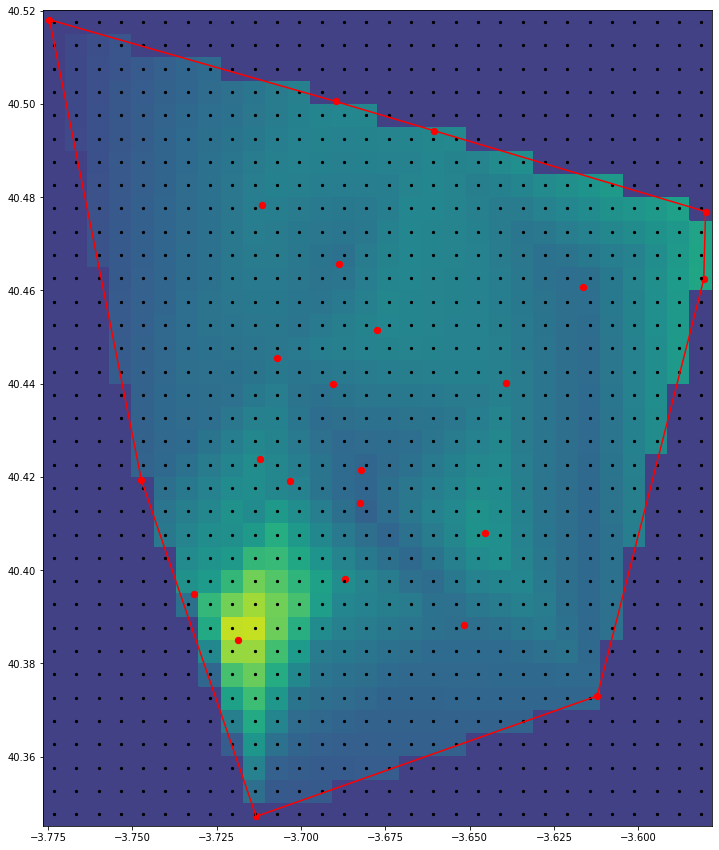

In [1489]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 15)
ax.pcolor(X, Y, arr[instant].T, vmin=0, vmax=288, shading='nearest')
ax.scatter(df_locs.loc[cols[1:], 'lng'], df_locs.loc[cols[1:], 'lat'], s=40, c='r')
ax.scatter(X, Y, c='k', s=5)
for simplex in hull.simplices:
    ax.plot(df_locs.iloc[simplex, 0], df_locs.iloc[simplex, 1], 'r-')
plt.show()

Compare original vs de-interpolated values:

In [1492]:
aux = interp_grid(arr[instant].T.ravel(), np.vstack([X.ravel(), Y.ravel()]).T,
            df_locs.loc[cols[1:], 'lng'].values, df_locs.loc[cols[1:], 'lat'].values,
            method='linear')#.transpose((1, 0))
print('Min value in arr: {:0.3}'.format(arr[instant].min()))
print('MAE: {:0.3}'.format(np.nanmean(np.abs((aux - sca[instant, 1:])))))

pd.DataFrame(np.vstack([sca[instant, 1:], aux, sca[instant, 1:] - aux]),
             index=['real', 'de-interp', 'difference'],
             columns=df_locs.index.values).round()

Min value in arr: 55.3
MAE: 11.2


,4,8,11,16,17,18,24,27,35,36,38,39,40,47,48,49,50,54,55,56,57,58,59,60
real,142.0,92.0,133.0,124.0,76.0,151.0,91.0,168.0,129.0,152.0,114.0,124.0,103.0,140.0,NaN,89.0,107.0,95.0,172.0,288.0,133.0,54.0,99.0,134.0
de-interp,138.0,95.0,130.0,123.0,NaN,125.0,68.0,NaN,129.0,145.0,115.0,122.0,105.0,139.0,113.0,96.0,110.0,81.0,NaN,252.0,108.0,NaN,104.0,86.0
difference,4.0,-3.0,3.0,1.0,NaN,26.0,23.0,NaN,-0.0,7.0,-1.0,2.0,-2.0,1.0,NaN,-7.0,-3.0,14.0,NaN,36.0,25.0,NaN,-5.0,48.0


Using linear (inside the convex hull) and minimum (outside) solves the first problem, but still de-interpolation is not accurate.

---

Using just nearest neighbors:

In [1348]:
date = '15/03/2010'
n_days = 7
g = 8
n = 'nn'

idx = (pd.DatetimeIndex([date], dayfirst=True) - pd.DatetimeIndex(['1/1/2010'], dayfirst=True)).days.values[0] * 24
times = pd.date_range(date, periods=n_days * 24, freq='1h')
times = times.format(date_format='%d/%m/%Y %H:%M')
arr = read_arr(n=n, g=g)[idx:idx+n_days*24]

idx = (pd.DatetimeIndex([date], dayfirst=True) - pd.DatetimeIndex(['1/1/2001'], dayfirst=True)).days.values[0] * 24
sca, cols = read_arr(dset='flat', n='rawComb', g=g, ret_cols=True)
sca = sca[idx:idx+n_days*24]

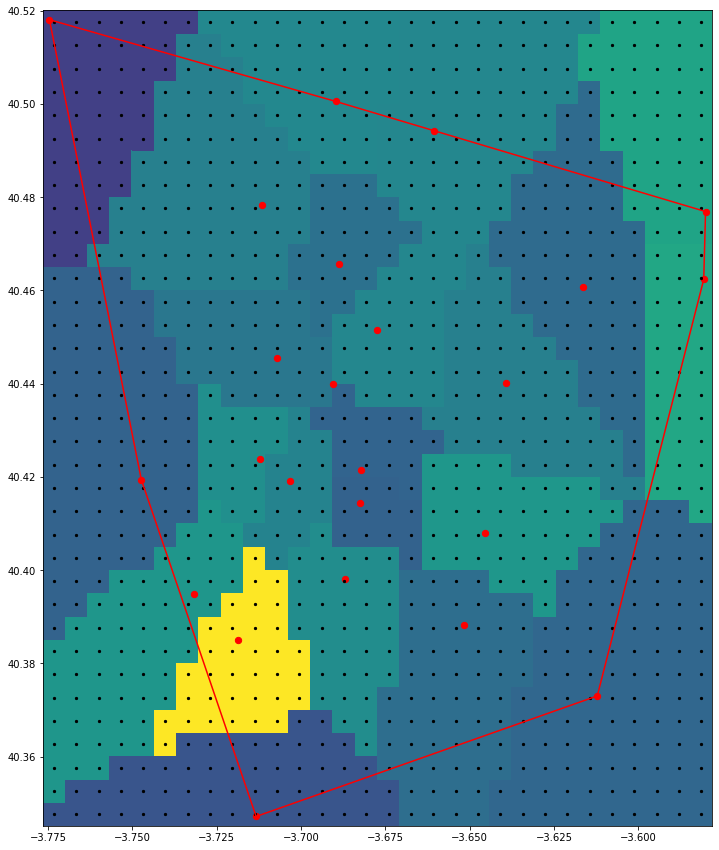

In [1349]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 15)
ax.pcolor(X, Y, arr[instant].T, vmin=0, vmax=288, shading='nearest')
ax.scatter(df_locs.loc[cols[1:], 'lng'], df_locs.loc[cols[1:], 'lat'], s=40, c='r')
ax.scatter(X, Y, c='k', s=5)
for simplex in hull.simplices:
    ax.plot(df_locs.iloc[simplex, 0], df_locs.iloc[simplex, 1], 'r-')
plt.show()

Compare original vs de-interpolated values:

In [1351]:
aux = interp_grid(arr[instant].T.ravel(), np.vstack([X.ravel(), Y.ravel()]).T,
            df_locs.loc[cols[1:], 'lng'].values, df_locs.loc[cols[1:], 'lat'].values,
            method='nearest')#.transpose((1, 0))
print('MAE: {:0.3}'.format(np.nanmean(np.abs((aux - sca[instant, 1:])))))

pd.DataFrame(np.vstack([sca[instant, 1:], aux, sca[instant, 1:] - aux]),
             index=['real', 'de-interp', 'difference'],
             columns=df_locs.index.values).round()

MAE: 0.0


,4,8,11,16,17,18,24,27,35,36,38,39,40,47,48,49,50,54,55,56,57,58,59,60
real,142.0,92.0,133.0,124.0,76.0,151.0,91.0,168.0,129.0,152.0,114.0,124.0,103.0,140.0,NaN,89.0,107.0,95.0,172.0,288.0,133.0,54.0,99.0,134.0
de-interp,142.0,92.0,133.0,124.0,76.0,151.0,91.0,168.0,129.0,152.0,114.0,124.0,103.0,140.0,92.0,89.0,107.0,95.0,172.0,288.0,133.0,54.0,99.0,134.0
difference,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Norm vs stand

In [1520]:
n = 'nn'
dset = '30x35_norm'

df = pd.DataFrame(columns=['min', 'mean', 'median', 'max', 'std'])
df.index.set_names(['code'], inplace=True)

for g in gc_map.keys():
    if g in g_exc:
        continue
    arr = read_arr(n=n, g=g, dset=dset)
    df.loc[g, 'min'] = arr.min()
    df.loc[g, 'mean'] = arr.mean()
    df.loc[g, 'median'] = np.median(arr)
    df.loc[g, 'max'] = arr.max()
    df.loc[g, 'std'] = arr.std()
df.reset_index(inplace=True)
df['gas'] = df.code.replace(c_map)
df = df[['code', 'gas', 'min', 'mean', 'median', 'max', 'std']]
df.to_csv('./results/madrid_gases_{}.csv'.format(dset), index=False)
df

,code,gas,min,mean,median,max,std
0,8,NO2,0.0,0.078657,0.058756,1.0,0.068138
1,1,SO2,0.0,0.062695,0.057692,1.0,0.047675
2,6,CO,0.0,0.022762,0.019417,1.0,0.023296
3,10,PM10,0.0,0.043878,0.033259,1.0,0.038663
4,9,PM2_5,0.0,0.049517,0.041860,1.0,0.037404
5,14,O3,0.0,0.211789,0.209315,1.0,0.141927
6,35,EBE,0.0,0.010599,0.004934,1.0,0.016634
7,7,NO,0.0,0.016791,0.003490,1.0,0.039540
8,12,NOx,0.0,0.028747,0.014692,1.0,0.042833
9,20,TOL,0.0,0.017342,0.010033,1.0,0.023453


In [1507]:
n = 'nn'
dset = '30x35_stand'

df = pd.DataFrame(columns=['min', 'mean', 'median', 'max', 'std'])
df.index.set_names(['code'], inplace=True)

for g in gc_map.keys():
    if g in g_exc:
        continue
    arr = read_arr(n=n, g=g, dset=dset)
    df.loc[g, 'min'] = arr.min()
    df.loc[g, 'mean'] = arr.mean()
    df.loc[g, 'median'] = np.median(arr)
    df.loc[g, 'max'] = arr.max()
    df.loc[g, 'std'] = arr.std()
df.reset_index(inplace=True)
df['gas'] = df.code.replace(c_map)
df = df[['code', 'gas', 'min', 'mean', 'median', 'max', 'std']]
df.to_csv('./results/madrid_gases_{}.csv'.format(dset), index=False)
df

,code,gas,min,mean,median,max,std
0,8,NO2,-1.220343,-0.069717,-0.360844,13.407990,0.996741
1,1,SO2,-1.360268,-0.009716,-0.117479,20.181406,1.027010
2,6,CO,-1.013592,-0.057848,-0.198263,40.975842,0.978205
3,10,PM10,-1.146032,-0.003644,-0.280110,24.889360,1.006594
4,9,PM2_5,-1.311847,0.002140,-0.201023,25.224510,0.992567
5,14,O3,-1.466329,0.033150,0.015637,5.613741,1.004857
6,35,EBE,-0.625388,0.021455,-0.324270,60.401218,1.015109
7,7,NO,-0.452796,-0.029900,-0.364888,24.732882,0.995835
8,12,NOx,-0.713251,-0.044432,-0.371427,22.552143,0.996530
9,20,TOL,-0.717798,0.034401,-0.282614,42.655582,1.017232


#### Animate mesh-grid

In [1469]:
%matplotlib notebook

In [1473]:
%matplotlib inline

Static:

In [1523]:
def plot3d(date, n_days, g, n, frame):
    idx = (pd.DatetimeIndex([date], dayfirst=True) - pd.DatetimeIndex(['1/1/2010'], dayfirst=True)).days.values[0] * 24
    times = pd.date_range(date, periods=n_days * 24, freq='1h')
    times = times.format(date_format='%d/%m/%Y %H:%M')
    arr = read_arr(n=n, g=g)[idx:idx+n_days*24]

    idx = (pd.DatetimeIndex([date], dayfirst=True) - pd.DatetimeIndex(['1/1/2001'], dayfirst=True)).days.values[0] * 24
    sca, cols = read_arr(dset='flat', n='rawComb', g=g, ret_cols=True)
    sca = sca[idx:idx+n_days*24]

    units = 'μg/m³' if g in gases_in_mug else 'mg/m³'
    vmin, vmax = arr.min(), arr.max()

    fig = plt.figure()
    ax = p3.Axes3D(fig)
    fig.set_size_inches(10, 8)
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    ax.set_xlabel(xlabel='Longitude [$\degree$]', fontsize=15, labelpad=12)
    ax.set_ylabel(ylabel='Latitude [$\degree$]', fontsize=15, labelpad=12)
    ax.set_zlabel(zlabel='{} [{}]'.format(gc_map[g], units), fontsize=15, labelpad=12)
    ax.set_zlim3d([vmin, vmax])
    ax.set_title('{}'.format(times[frame]), fontsize=15)
    ax.plot_surface(X, Y, arr[frame].T, cmap='viridis', alpha=0.6, norm=norm)
    ax.scatter(df_locs.loc[cols[1:], 'lng'], df_locs.loc[cols[1:], 'lat'], sca[frame, 1:], s=20, c='r')
    plt.show()

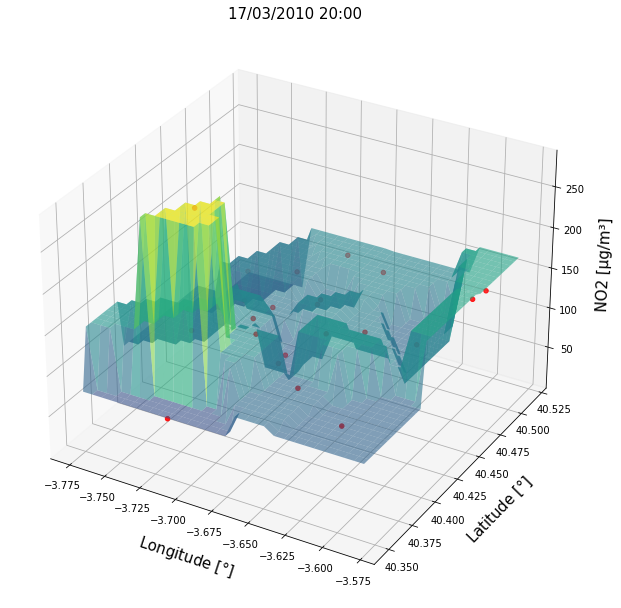

In [1524]:
date = '15/03/2010'
n_days = 7
g = 8
n = 'nn'
frame = 68

plot3d(date, n_days, g, n, frame)

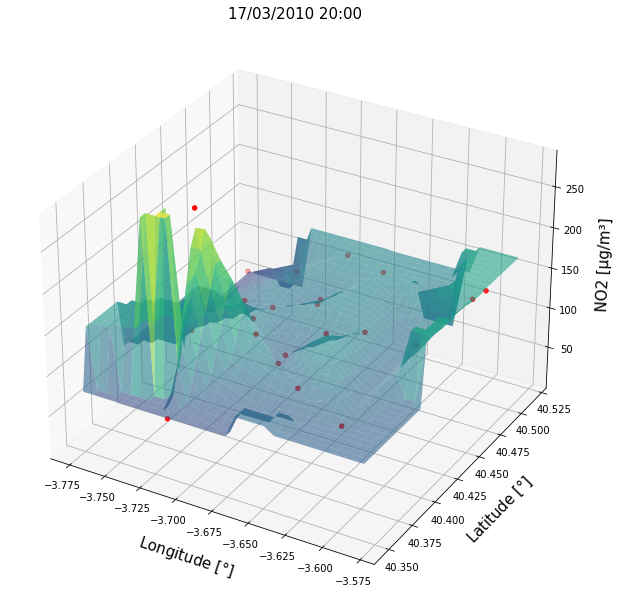

In [1526]:
date = '15/03/2010'
n_days = 7
g = 8
n = 'linearNN'
frame = 68

plot3d(date, n_days, g, n, frame)

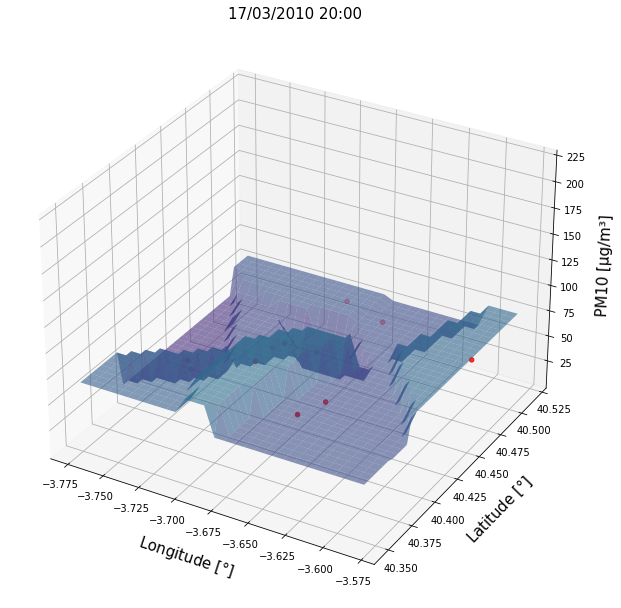

In [1525]:
date = '15/03/2010'
n_days = 7
g = 10
n = 'nn'
frame = 68

plot3d(date, n_days, g, n, frame)

Animated:

In [1601]:
def update(frame, ax, arr, sca, cols, times, vmin, vmax, norm, units, step):
    #if (frame % 100) == 0:
    #    print('Frame:', frame)
    ax.clear()
    ax.set_xlabel(xlabel='Longitude [$\degree$]', fontsize=15, labelpad=12)
    ax.set_ylabel(ylabel='Latitude [$\degree$]', fontsize=15, labelpad=12)
    ax.set_zlabel(zlabel='{} [{}]'.format(gc_map[g], units), fontsize=15, labelpad=12)
    ax.set_zlim3d([vmin, vmax])
    # Note: For some reason, I only managed to make the title visible setting y=1 here:
    ax.set_title('{}'.format(times[frame]), fontsize=15, y=1)
    ax.plot_surface(X, Y, arr[frame*step].T, cmap='viridis', alpha=0.6, norm=norm)
    if sca is not None:
        ax.scatter(df_locs.loc[cols[1:], 'lng'], df_locs.loc[cols[1:], 'lat'], sca[frame, 1:], s=20, c='r')
    return _

def animate(date, n_days, g, n, dset='30x35_raw', step=1):
    # Load grid data and prepare time labels
    idx = (pd.DatetimeIndex([date], dayfirst=True) - pd.DatetimeIndex(['1/1/2010'], dayfirst=True)).days.values[0] * 24
    times = pd.date_range(date, periods=n_days * 24, freq='1h')
    times = times.format(date_format='%d/%m/%Y %H:%M')
    arr = read_arr(n=n, g=g, dset=dset)[idx:idx+n_days*24]
    
    # Load flat data
    if os.path.exists('../data/madrid/clean/01h_flat_{}Comb.h5'.format(dset.split('_')[-1])):
        idx = (pd.DatetimeIndex([date], dayfirst=True) - pd.DatetimeIndex(['1/1/2001'], dayfirst=True)).days.values[0] * 24
        sca, cols = read_arr(dset='flat', n='{}Comb'.format(dset.split('_')[-1]), g=g, ret_cols=True)
        sca = sca[idx:idx+n_days*24]
    else:
        sca, cols = None, None
    
    # For the y-axis
    units = 'μg/m³' if g in gases_in_mug else 'mg/m³'
    vmin, vmax = arr.min(), arr.max()

    # Animate!
    fig = plt.figure()
    ax = p3.Axes3D(fig)
    fig.set_size_inches(10, 8)
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    anim = animation.FuncAnimation(fig, update, frames=arr.shape[0]//step,
                                   repeat=True, fargs=(ax, arr, sca, cols, times, vmin, vmax, norm, units, step))
    anim.save('./animations/{}_{}_{}_{}.mp4'.format(dset.split('_')[-1], n, gc_map[g], ''.join(date.split('/')[::-1])))
    plt.close(fig)

In [1530]:
# Starting date
date = '15/03/2010'
# Number of days that the animation lasts
n_days = 7
# Gas id
g = 8
# Dataset
n = 'linearNN'

animate(date, n_days, g, n)

In [1598]:
# Starting date
date = '15/03/2010'
# Number of days that the animation lasts
n_days = 7

for dset in ['30x35_norm', '30x35_stand']:
    for n in ['nn']:#['linearNN', 'cubicNN', 'linearMin']:
        for g in [8, 10, 1]:
            animate(date, n_days, g, n, dset)

## Holidays

The Comunity of Madrid provides a datset of [historical regional and local holidays](https://datos.comunidad.madrid/catalogo/dataset/festivos_regionales_locales_historico) from 1998 until 2020:

In [1665]:
df_floc = pd.read_csv(os.path.join(folder, 'other/festivos_locales_historicos.csv'),
                      sep=';', encoding='latin', parse_dates=[-1])
print(df_floc.shape)
df_floc.head()

(8334, 6)


,año,municipio_codigo,municipio_nombre,entidad_codigo,entidad_nombre,fecha_festivo
0,1998,2,Ajalvir,0,Ajalvir,1998-02-03
1,1998,2,Ajalvir,0,Ajalvir,1998-05-15
2,1998,3,Alameda del Valle,0,Alameda del Valle,1998-02-02
3,1998,3,Alameda del Valle,0,Alameda del Valle,1998-09-08
4,1998,5,Alcalá de Henares,0,Alcalá de Henares,1998-08-06


In [1666]:
df_freg = pd.read_csv(os.path.join(folder, 'other/festivos_regionales_historicos.csv'),
                      sep=';', encoding='latin', parse_dates=[1])
print(df_freg.shape)
df_freg.head()

(297, 3)


,año,fecha_festivo,festividad
0,1998,1998-01-01,Año Nuevo
1,1998,1998-01-06,Epifanía del Señor
2,1998,1998-03-19,San José
3,1998,1998-04-09,Jueves Santo
4,1998,1998-04-10,Viernes Santo


In [1667]:
df_floc = df_floc[df_floc.municipio_nombre == 'Madrid'][['año', 'fecha_festivo']]
df_floc['festividad'] = 'Festivo local de Madrid'
df_floc.head()

,año,fecha_festivo,festividad
172,1998,1998-05-15,Festivo local de Madrid
173,1998,1998-11-09,Festivo local de Madrid
532,1999,1999-05-15,Festivo local de Madrid
533,1999,1999-11-09,Festivo local de Madrid
896,2000,2000-05-15,Festivo local de Madrid


In [1679]:
df_fest = pd.concat([df_floc, df_freg])
df_fest.sort_values('fecha_festivo', inplace=True)
df_fest.columns = ['year', 'date', 'holiday']
df_fest

,year,date,holiday
0,1998,1998-01-01,Año Nuevo
1,1998,1998-01-06,Epifanía del Señor
2,1998,1998-03-19,San José
3,1998,1998-04-09,Jueves Santo
4,1998,1998-04-10,Viernes Santo
...,...,...,...
293,2020,2020-11-02,traslado Todos los Santos
8143,2020,2020-11-09,Festivo local de Madrid
294,2020,2020-12-07,traslado Día Constitución Española
295,2020,2020-12-08,Inmaculada Concepción


In [1680]:
df_fest.to_csv(os.path.join(folder, 'other/holidays-1998-2020.csv'), index=False)

In [1683]:
7 * 4 * 12 * 12

4032

In [1685]:
7 * 5 * 12 * 10

4200

In [1687]:
6 * 6 * 12 * 10

4320

## AEMET weather

### Helpful

In [5]:
folder = '../data/madrid/'

In [514]:
df_met = pd.read_csv(folder + 'other/stations_aemet.csv')

m_map = OrderedDict(zip(df_met.st_name, df_met.id))
mc_map = OrderedDict(zip(df_met.id, df_met.st_name))
df_met

,id,st_name,lng,lat
0,3126Y,El Goloso,-3.7119,40.5614
1,3129,Barajas,-3.5556,40.4667
2,3194U,C. Universitaria,-3.7242,40.4517
3,3195,Retiro,-3.6781,40.4119
4,3196,Cuatro Vientos,-3.7861,40.3756
5,3200,Getafe,-3.7222,40.2994


In [517]:
slices_d ={
    'temperature': slice('T00', 'T23'),
    'precipitation': slice('PH01', 'PH24'),
    'wind': slice('DIR_00', 'VEL_23'),
    'humidity': slice('HU00', 'HU18'),
    'cloud': slice('TOT_07', 'TOT_18', 5)
}

### Transfer raw data

The final file will look like this:
```
01h_weather_raw.h5 (file)
|-- variable (carray) -> values: time (rows) + stations (columns)
```

In [698]:
def process_weather_variable(df, st, v):
    ret = df.set_index('date')
    ret = ret.loc[(ret.INDICATIVO == st), slices_d[v]]
    ret = ret.stack(dropna=False).reset_index()
    ret.columns = ['date', 'hour', 'value']
    # Extract and include hour
    ret.hour = ret.apply(lambda x: int(x['hour'][-2:]), axis=1)
    ret.date += (ret['hour'] - (1 if v == 'precipitation' else 0)) * 3600
    ret = ret.set_index('date')
    if v == 'precipitation':
        ret.replace(-3.0, .0, inplace=True) # -3 means precipitation < 0.1 mm
    elif v == 'wind':
        # First, some adjustments:
        ret.iloc[0::2, -1] = ret.iloc[0::2, -1].replace(88, np.nan) # <-- 88 means no data
        ret.iloc[0::2, -1] = ret.iloc[0::2, -1].replace(99, np.nan) # <-- 99 means variable wind
        ret.iloc[0::2, -1] = ret.iloc[0::2, -1].replace(36.0, 0.0) # <-- 360º equiv. to 0º
        ret.iloc[0::2, -1] = ret.iloc[0::2, -1] * 10 # <-- adjust degrees units (decenas de grado)
        # Then, convert direction to radians
        wd_rad = ret.iloc[0::2, -1].values * np.pi / 180
        # Now, calculate the wind X and Y components (and convert from km/h to m/s??)
        w_x = ret.iloc[1::2, -1].values * np.cos(wd_rad) #/ 3600 * 1000
        w_y = ret.iloc[1::2, -1].values * np.sin(wd_rad) #/ 3600 * 1000
        ret.iloc[0::2, -1] = w_x
        ret.iloc[1::2, -1] = w_y
        return (ret.iloc[0::2].value.round(1).copy(), ret.iloc[1::2].value.round(1).copy())
    elif v == 'cloud':
        ret.replace('N', np.nan, inplace=True) # N means sky not visible due to dust or smoke
        ret = ret.astype(float)
    return ret.value

def transfer_raw_weather(raw_files, out_path):
    # Parameters for the hdf5 file
    filters = tb.Filters(complib='blosc:lz4hc', complevel=9)
    dtype = tb.Float64Atom()
    tic = time.time()
    for v, f in raw_files.items():
        print('Working on {}...'.format(v))
        # Read whole table and add date column
        df = pd.read_csv(os.path.join(folder, 'raw', 'aemet', f), sep=';', encoding='latin-1', low_memory=False)
        df['date'] = pd.to_datetime({'year': df.AÑO, 'month':df.MES, 'day':df.DIA})
        start_date, end_date = df.date.min(), df.date.max() + dt.timedelta(hours=23)
        df.date = df.date.astype('int64') // 1e9
        df.INDICATIVO = df.INDICATIVO.astype(str)
        # Create empty table to add new columns based on the date range
        df_v = pd.DataFrame(index=pd.date_range(start_date, end_date, freq='1h').astype('int64') // 1e9,
                            columns=mc_map.keys(), dtype=float)
        if v == 'wind': # we need 2 (x and y coords)
            df_v = (df_v.copy(), df_v.copy())
        for st in mc_map.keys():
            #print('\tStation', st, mc_map[st])
            # if weather station st does not collect variable v, pass
            if df.loc[(df.INDICATIVO == st)].shape[0] == 0: continue
            aux = process_weather_variable(df, st=st, v=v)
            if v != 'wind':
                df_v.loc[aux.index.values, st] = aux
            else:
                df_v[0].loc[aux[0].index.values, st], df_v[1].loc[aux[1].index.values, st] = aux[0], aux[1]
        # Now, transfer into HDF5
        with tb.open_file(out_path, mode='a', filters=filters) as h5_file, \
             warnings.catch_warnings() as w:
            warnings.simplefilter('ignore', tb.NaturalNameWarning)
            if v != 'wind':
                h5_file.create_carray(obj=df_v.reset_index().values, atom=dtype, where='/',
                                      name='{}'.format(v), createparents=True)
            else:
                h5_file.create_carray(obj=df_v[0].reset_index().values, atom=dtype, where='/',
                                      name='{}-x'.format(v), createparents=True)
                h5_file.create_carray(obj=df_v[1].reset_index().values, atom=dtype, where='/',
                                      name='{}-y'.format(v), createparents=True)
    with tb.open_file(out_path, mode='a', filters=filters) as h5_file:
        # Add meta:
        node = h5_file.root
        node._v_attrs['columns'] = ['time_since_epoch'] + list(mc_map.keys())
        node._v_attrs['m_map'] = m_map
        node._v_attrs['mc_map'] = mc_map
        node._v_attrs['time_resolution'] = '01h'
        node._v_attrs['units'] = OrderedDict({
            'temperature': 'tenth of degrees Celsius',
            'precipitation': 'tenth of milimiter',
            'wind-x': 'km/h',
            'wind-y': 'km/h',
            'humidity': 'percentage',
            'cloud': 'eights of sky'
        })
        # Start-date matches on all variables (checked), so we add the last one
        node._v_attrs['initial_dt'] = dt.datetime.utcfromtimestamp(df_v.reset_index().iloc[0, 0])
    return 'It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic)))

In [700]:
raw_files = {
    'temperature' : 'temperatura_990211906.csv',
    'precipitation': 'precipitacion_990211906.csv',
    'wind': 'Viento_990211906.csv',
    'humidity': 'Humedad_990211906.csv',
    'cloud': 'Nubes_990211906.csv'
}

out_path = '../data/madrid/clean/01h_weather_raw.h5'
transfer_raw_weather(raw_files, out_path)

Working on temperature...
Working on precipitation...
Working on wind...
Working on humidity...
Working on cloud...


'It took 00:00:19 in total'

### Fill gaps

From `'../data/madrid/clean/01h_weather_raw.h5'`, we do the following 3 steps:
- **Step 1**: Fill gaps based on the station that has the least, which is Barajas.
- **Step 2**: Fill remaining gaps (which are few) based on the next best station, which is Retiro.
- **Step 3**: Finally, forward-fill non-existing data for humidity and clouds.

The final file will look like this:
```
01h_weather_filled.h5 (file)
|-- variable (carray) -> values: time (rows) + stations (columns)
```

In [798]:
def fill_weather(in_path, out_path):
    # Parameters for the hdf5 file
    filters = tb.Filters(complib='blosc:lz4hc', complevel=9)
    dtype = tb.Float64Atom()
    tic = time.time()
    # Now, transfer into HDF5
    with tb.open_file(in_path, mode='r', filters=filters) as h5_in, \
         tb.open_file(out_path, mode='a', filters=filters) as h5_out, \
         warnings.catch_warnings() as w:
        warnings.simplefilter('ignore', tb.NaturalNameWarning)
        for v in h5_in.root._v_attrs['units'].keys():
            arr = h5_in.root[v][:]
            # Step 1:
            rc = np.argwhere(np.isnan(arr))
            r = rc.copy()
            r[:, 1] = 2 # <-- Fill using the station with the least gaps ('3129': 'Barajas')
            arr[rc[:, 0], rc[:, 1]] = arr[r[:, 0], r[:, 1]]
            # Step 2:
            rc = np.argwhere(np.isnan(arr))
            r = rc.copy()
            r[:, 1] = 4 # <-- Fill using the next best station ('3195', 'Retiro')
            arr[rc[:, 0], rc[:, 1]] = arr[r[:, 0], r[:, 1]]
            # Step 3:
            if v == 'humidity' or v == 'cloud':
                for idx in range(arr.shape[0]):
                    mask = np.isnan(arr[idx, :])
                    arr[idx, mask] = arr[idx - 1, mask]
            if v == 'cloud':
                arr[:8, 1:] = arr[8, 1:]
            # Now, save to file
            h5_out.create_carray(obj=arr, atom=dtype, where='/',
                                  name='{}'.format(v), createparents=True)
        # Add meta:
        node = h5_out.root
        node._v_attrs['columns'] = h5_in.root._v_attrs['columns']
        node._v_attrs['m_map'] = m_map
        node._v_attrs['mc_map'] = mc_map
        node._v_attrs['time_resolution'] = '01h'
        node._v_attrs['units'] = h5_in.root._v_attrs['units']
        node._v_attrs['initial_dt'] = h5_in.root._v_attrs['initial_dt']
    return 'It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic)))

In [800]:
in_path = '../data/madrid/clean/01h_weather_raw.h5'
out_path = '../data/madrid/clean/01h_weather_filled.h5'
fill_weather(in_path, out_path)

'It took 00:00:01 in total'

### Normalize

From `'../data/madrid/clean/01h_weather_filled.h5'`

The final file will look like this:
```
01h_weather_filledNormSep.h5 (file)
|-- variable (carray) -> values: time (rows) + stations (columns)
```

In [813]:
def norm_weather(in_path, out_path):
    # Parameters for the hdf5 file
    filters = tb.Filters(complib='blosc:lz4hc', complevel=9)
    dtype = tb.Float64Atom()
    tic = time.time()
    # Now, transfer into HDF5
    with tb.open_file(in_path, mode='r', filters=filters) as h5_in, \
         tb.open_file(out_path, mode='a', filters=filters) as h5_out, \
         warnings.catch_warnings() as w:
        warnings.simplefilter('ignore', tb.NaturalNameWarning)
        for v in h5_in.root._v_attrs['units'].keys():
            arr = h5_in.root[v][:]
            arr[:, 1:] = (arr[:, 1:] - arr[:, 1:].min(axis=0)) / (arr[:, 1:].max(axis=0) - arr[:, 1:].min(axis=0))
            # Now, save to file
            h5_out.create_carray(obj=arr.round(3), atom=dtype, where='/',
                                  name='{}'.format(v), createparents=True)
        # Add meta:
        node = h5_out.root
        node._v_attrs['columns'] = h5_in.root._v_attrs['columns']
        node._v_attrs['m_map'] = m_map
        node._v_attrs['mc_map'] = mc_map
        node._v_attrs['time_resolution'] = '01h'
        node._v_attrs['units'] = h5_in.root._v_attrs['units']
        node._v_attrs['initial_dt'] = h5_in.root._v_attrs['initial_dt']
    return 'It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic)))

In [815]:
in_path = '../data/madrid/clean/01h_weather_filled.h5'
out_path = '../data/madrid/clean/01h_weather_filledNormSep.h5'
norm_weather(in_path, out_path)

'It took 00:00:00 in total'

From `'../data/madrid/clean/01h_weather_filledNormSep.h5'`, we now:
- combine all variables into a single table, and
- exclude clouds.

The final file will look like this:
```
01h_weather_filledNorm.h5 (file)
|-- weather (carray) -> values: time (rows) + stations (columns, for all variables)
```

In [857]:
def join_weather(in_path, out_path):
    # Parameters for the hdf5 file
    filters = tb.Filters(complib='blosc:lz4hc', complevel=9)
    dtype = tb.Float64Atom()
    tic = time.time()
    # Now, transfer into HDF5
    with tb.open_file(in_path, mode='r', filters=filters) as h5_in, \
         tb.open_file(out_path, mode='a', filters=filters) as h5_out, \
         warnings.catch_warnings() as w:
        warnings.simplefilter('ignore', tb.NaturalNameWarning)
        cols = ['time_since_epoch']
        for v in h5_in.root._v_attrs['units'].keys():
            if v == 'temperature':
                arr = h5_in.root[v][:]
            elif v == 'cloud':
                continue
            else:
                arr = np.hstack([arr, h5_in.root[v][:, 1:]])
            cols += [v + '-' + st for st in mc_map.keys()]
        # Now, save to file
        h5_out.create_carray(obj=arr, atom=dtype, where='/',
                              name='weather', createparents=True)
        # Add meta:
        node = h5_out.root
        node._v_attrs['columns'] = cols
        node._v_attrs['m_map'] = m_map
        node._v_attrs['mc_map'] = mc_map
        node._v_attrs['time_resolution'] = '01h'
        node._v_attrs['units'] = h5_in.root._v_attrs['units']
        node._v_attrs['initial_dt'] = h5_in.root._v_attrs['initial_dt']
    return 'It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic)))

In [859]:
in_path = '../data/madrid/clean/01h_weather_filledNormSep.h5'
out_path = '../data/madrid/clean/01h_weather_filledNorm.h5'
join_weather(in_path, out_path)

'It took 00:00:00 in total'

### Transfer into mesh-grid

From `'../data/madrid/clean/01h_weather_raw.h5'`

## Next